# UMAP LEARN

## Plan

* Supervised and unupervised analysis on pulmonary carcinoid data :
    * Graph
    * Local neighborhood
    * Clustering Kmean - Dbscan - KNN ?
* Unsupervised analysis on pulmonary carcinoid data :
    * Graph
    * Local neighborhood
    * Clustering Kmean - Dbscan - KNN ?
    
*  Unsupervised analysis on pulmonary carcinoid data and PCA:

## Librairies

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit ,train_test_split, StratifiedKFold , StratifiedShuffleSplit
import umap
import math
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score , recall_score , silhouette_score, accuracy_score,precision_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import pdist
from matplotlib.colors import ListedColormap
from scipy.stats import mode
import itertools
import geopandas # For pysal 
from sklearn.utils.multiclass import unique_labels
import pysal
from sklearn.metrics import confusion_matrix
from pysal.lib.weights.util import min_threshold_distance
from pysal.lib.weights.distance import DistanceBand
from pysal.explore.esda.moran import Moran

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: T

In [2]:
import jaccard_set_distance as Neighborhood

## Function 

In [3]:
def label_pred(y_test, pred_label):
    """This function allows to assign cluster label with their orginal label.
    n_class is the number of class"""
    #print('pred_label', pred_label)
    #print('y_test', y_test)
    Assign_clustring_labels = pd.DataFrame()
    Assign_clustring_labels["y_test"] = y_test
    Assign_clustring_labels["pred_label"] = pred_label
    tab = pd.crosstab( Assign_clustring_labels["y_test"],  Assign_clustring_labels["pred_label"])
    #print(tab)
    P = list(itertools.permutations(tab.columns.values))
    #print("P", P)
    original_labels = list(tab.index.values)
    #print('original_labels', original_labels)
    List_dict_label=[]
    for i in range(len(P)):
        dict_label = {}
        for j in range(len(original_labels)):
            dict_label[P[i][j]] =original_labels[j]
            List_dict_label.append(dict_label)
        
    acc_score=[]
    for i in range(len(List_dict_label)):
        c_dict = List_dict_label[i]
        #print('c_dict',c_dict)
        y_labels = []
        for j in range(len(pred_label)):
            y_labels.append(c_dict[pred_label[j]])
        acc_score.append(accuracy_score(y_labels, y_test))
        #print('c acc_score',accuracy_score(y_labels, y_test))
        
    f_acc_score = []    
    for i in range(0,len(acc_score), len(original_labels)):
        #print(i)
        f_acc_score.append(acc_score[i])
    
    #print("f_acc_score", f_acc_score)
    acc_score=f_acc_score
    acc_score= list(set(acc_score))
   
    c_dict= {}
    #print("acc_score", acc_score)
    #print("acc_score.index(max(acc_score))", acc_score.index(max(acc_score)))
    #print("P[acc_score.index(max(acc_score))]", P[acc_score.index(max(acc_score))])
    for j in range(len(original_labels)):
        c_dict[P[acc_score.index(max(acc_score))][j]]= original_labels[j]
    #c_dict ={ P[acc_score.index(max(acc_score))][0]:"Atypical",P[acc_score.index(max(acc_score))][1]:"Typical" ,P[acc_score.index(max(acc_score))][2]:"LCNEC" }
    #print("c_dict",c_dict)
    final_label = []
    for j in range(len(pred_label)):
       # print("pred_label[j]", pred_label[j])
       # print("c_dict[pred_label[j]]", c_dict[pred_label[j]])
       # print('')
        final_label.append(c_dict[pred_label[j]])
    final_acc_score = accuracy_score(final_label, y_test)  
    
    return final_acc_score , final_label

In [4]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}

## Import data 
* `data_lv_50_type` is the expression data frame of 6399 genes which have the largest variance for samples whose type is Atypical, Typical, or LCNEC
* `coords_mofa_expr_lnen` Mofa coords with expression data for LNEN samples

In [5]:
data_lv_50_type3 =  pd.read_csv("t_data_vst_50_type_3class.tsv", sep="\t")
data_lv_50_type3.shape
coords_mofa_expr_lnen = pd.read_csv("MOFA_Expr_coord_sort.txt", sep="\t")

data_lv_50_type3.head

ml_pred  = pd.read_csv("ML_pred_fig1_df.tsv", sep="\t")
cluster_lnen  = pd.read_csv("cluster_LNEN.tsv", sep="\t")

coords_mofa_expr_lnen.head()
Sample_ID_df =pd.DataFrame(data_lv_50_type3["Sample_ID"] )
coords_mofa_expr_lnen_v2 = pd.merge(coords_mofa_expr_lnen, Sample_ID_df, on='Sample_ID', how='inner')
coords_mofa_expr_lnen = coords_mofa_expr_lnen_v2

spatial_attributes = pd.read_csv("Spatial_analysis_attribute.tsv", sep="\t")
spatial_attributes.head()
spatial_attributes = spatial_attributes.iloc[:,1:4]
spatial_attributes.head()

,OTP,ANGPTL3,Dendritic_cell
0,4.892365,12.661357,0.000000
1,13.981876,10.949075,0.008448
2,14.250489,8.717908,0.017431
3,12.801411,7.281603,0.006153
4,1.696912,13.955985,0.008023


In [6]:
data_lv_50_type3.shape

(152, 6011)

**Set labels**

In [343]:
lv_50_type = data_lv_50_type3.iloc[:,6010]
typeN  = []
for i in range(len(lv_50_type)):
    if lv_50_type[i]== 'Atypical':
        typeN.append(1)
    elif lv_50_type[i]== 'Typical':
        typeN.append(2)
    elif lv_50_type[i]== 'LCNEC':
        typeN.append(3)
    else :
        print("WARNING i = ", i)
        break


## Effect of supervised analysis

### Graphical experiment

#### Unsupervised Dimensionality Reduction

###### PCA

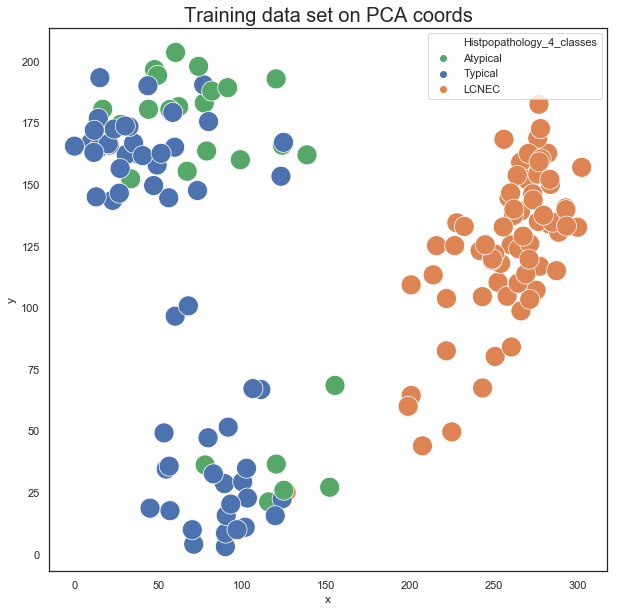

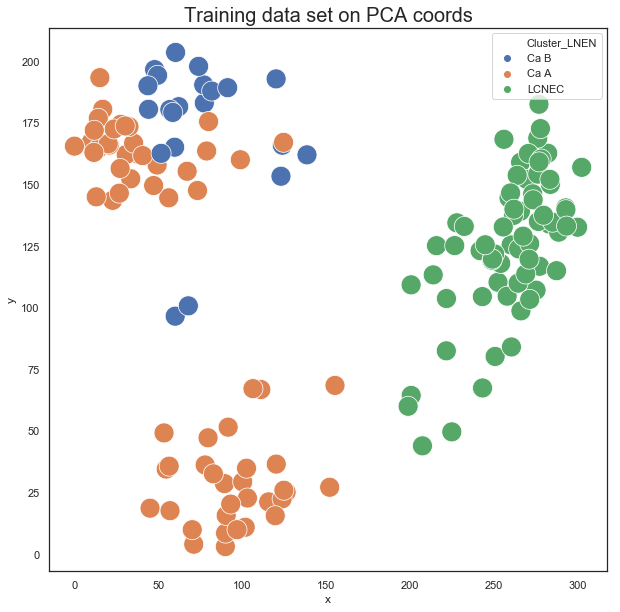

In [7]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(coords_mofa_expr_lnen.iloc[:, 1], coords_mofa_expr_lnen.iloc[:, 2],  hue=lv_50_type ,s=400, palette=palette)
plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()

palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(coords_mofa_expr_lnen.iloc[:, 1], coords_mofa_expr_lnen.iloc[:, 2],  hue=cluster_lnen.iloc[:,1] ,s=400)
plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()

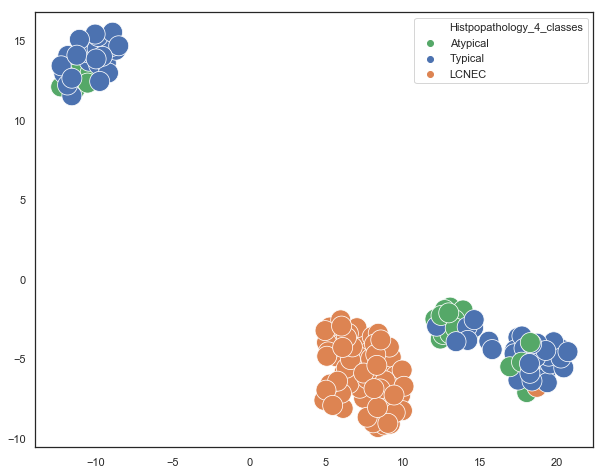

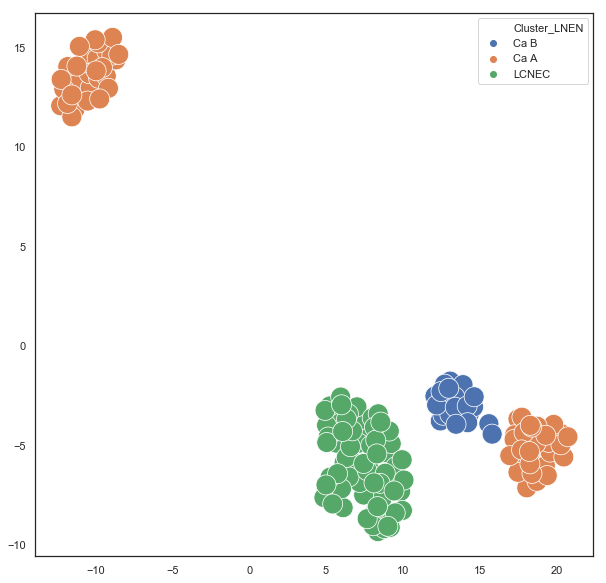

In [8]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6010]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding = umap.UMAP(min_dist=1).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1], s=400, hue=lv_50_type, palette=palette)
plt.show()



sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1],  hue=cluster_lnen.iloc[:,1] ,s=400)
#plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()

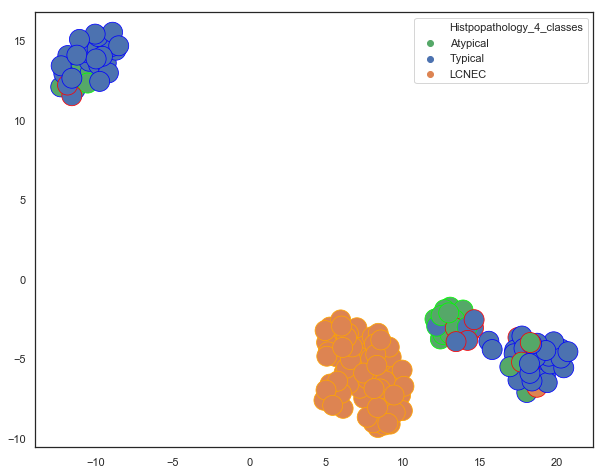

In [9]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", "Unclassified":"C3"}
edges_col = []
for i in ml_pred.iloc[:,1]:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    elif i == 'Unclassified':
        edges_col.append("red")
    else :
        print("warning")


sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1],  hue=lv_50_type, edgecolor=  edges_col , s=400, palette=palette)
plt.show()

#### Supervised Dimensionality Reduction

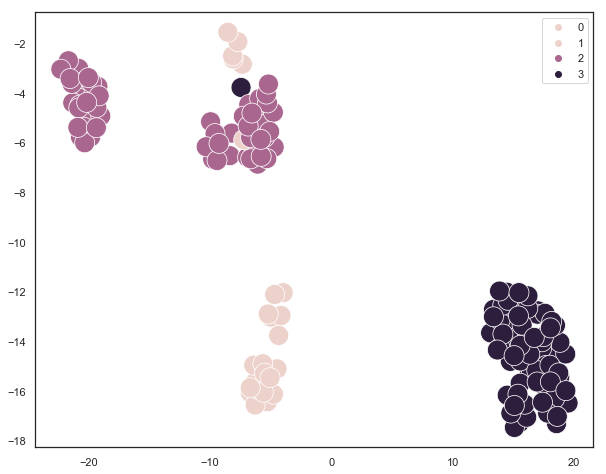

In [10]:
embedding = umap.UMAP(min_dist=1).fit_transform(lv_50_data, y=typeN)

sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=400, hue=typeN)
plt.show()

**Legend complement :**
* 1 Atypical
* 2 Typical
* 3 LCNEC

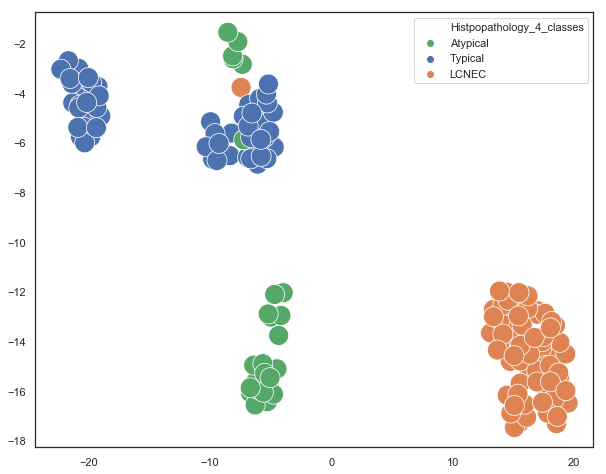

In [11]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", "Unclassified":"C3"}
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=lv_50_type, s=400, palette=palette)
plt.show()

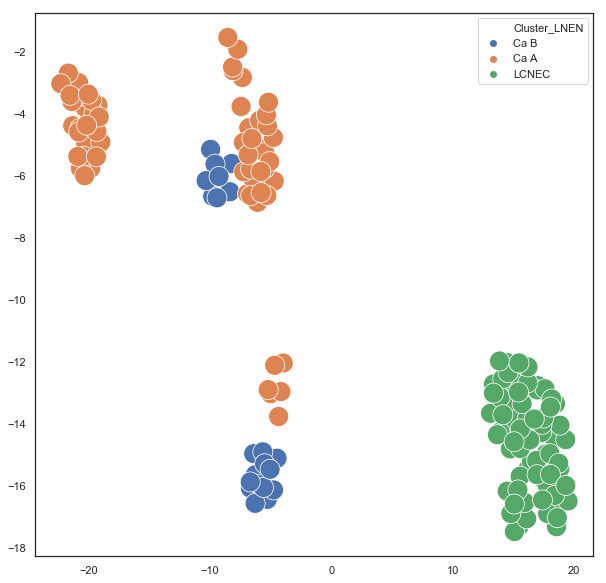

In [12]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=cluster_lnen.iloc[:,1] ,s=400)
#plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()

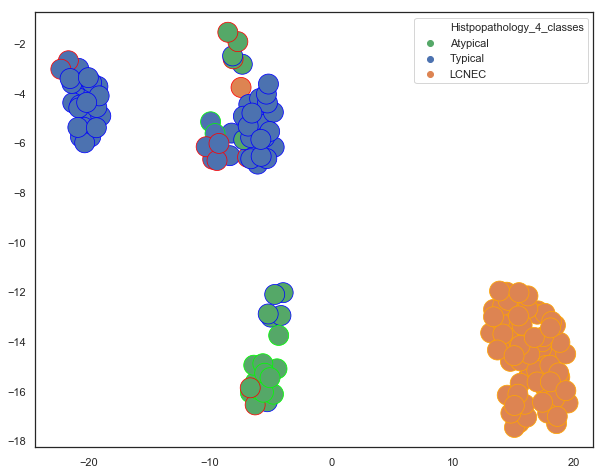

In [13]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", "Unclassified":"C3"}
edges_col = []
for i in ml_pred.iloc[:,1]:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    elif i == 'Unclassified':
        edges_col.append("red")
    else :
        print("warning")


sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=lv_50_type, edgecolor=  edges_col , s=400, palette=palette)
plt.show()

**Remark : New cluster of typical**
### Local Neighbohood metrics
##### Distance

In [14]:
standard_embedding_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_df['X'] = standard_embedding[:,0]
standard_embedding_df['Y'] = standard_embedding[:,1]
embedding_df = pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_df['X'] = embedding[:,0]
embedding_df['Y'] = embedding[:,1]
d_unsupervised =  Neighborhood.distance_matrix(standard_embedding_df)
d_supervised = Neighborhood.distance_matrix(embedding_df)
Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn

In [15]:
d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

#### Write Coords

In [16]:
#standard_embedding_df.to_csv(path_or_buf='Unsupervised_Coords.txt', sep='\t')
#embedding_df.to_csv(path_or_buf='Supervised_Coords.txt', sep='\t')

##### CP

In [17]:
#cp1 = Neighborhood.centrality_preservation(d_unsupervised ,  Dist_pulmonary , range(1,len(standard_embedding[:,0]),10),"CP_pulmo_R_unsupervised")
#cp2 = Neighborhood.centrality_preservation(d_supervised ,  Dist_pulmonary , range(1,len(standard_embedding[:,0]),10),"CP_pulmo_R_supervised")

In [18]:
#cp3 = Neighborhood.centrality_preservation(d_mofa_expr , Dist_pulmonary ,  range(1,d_mofa_expr.shape[0],10)  ,"CP_pulmo_R_MOFA")

**Results**

CP2 on projection CP2 unsupervised type :
http://rpubs.com/mathiane/UMAP_R_CP_Supervised
http://rpubs.com/mathiane/UMAP_R_US_CP2
Interprétation difficile

CPN on projection CP2 unsupervised type :
http://rpubs.com/mathiane/UMAP_R_US_CPN
http://rpubs.com/mathiane/UMAP_R_US_CPN_next


CP2 on projection CP2 supervised type :
http://rpubs.com/mathiane/UMAP_R_CP_Supervised
http://rpubs.com/mathiane/UMAP_R_CP_Sup_n
Interprétation difficile


CPN on projection CP2 supervised type :

http://rpubs.com/mathiane/UMAP_S_CPN
http://rpubs.com/mathiane/UMAP_S_CPN_next


**Centralité gobalement plus conservé dans le cas non supervisé**

![CPMeanbyk](cp_supervised_unsupervised.png)

#### Seq and Set

In [19]:
#Neighborhood.main_f(d_unsupervised , Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_unsuper_R" , "seq_diff_pulmo_unsuper_R" , True )
#Neighborhood.main_f(d_supervised, Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_super_R" , "seq_diff_pulmo_super_R" , True )
#Neighborhood.main_f(d_mofa_expr, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_MOFA" , "seq_diff_pulmo_R_MOFA" , True )

![SetDiffbyk](set_supervised_unsupervised_v2.png)
![SeqDiffbyk](seq_diff_by_k.png)

### Clustering

In [20]:
min_dist_to_test = np.arange(0,3, 1.5)
#n_neighbors_to_test = range(2,210)

In [21]:
data_lv_50_type3.head()
data_lv_50_type3.shape

(152, 6011)

##### Stratified cross validation

In [22]:
CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]

In [23]:
y_test = list(y_test)
print('len y test', len(y_test))
print(y_test.count('LCNEC') , y_test.count('Typical') , y_test.count('Atypical'))
y_test.count('LCNEC')/len(y_test) , y_test.count('Typical')/len(y_test) , y_test.count('Atypical')/len(y_test)

len y test 38
16 13 9


(0.42105263157894735, 0.34210526315789475, 0.23684210526315788)

In [24]:
y_train = list(y_train)
y_train.count('LCNEC')/len(y_train) , y_train.count('Typical')/len(y_train) , y_train.count('Atypical')/len(y_train)

(0.4649122807017544, 0.39473684210526316, 0.14035087719298245)

In [25]:
lv_50_type = list(lv_50_type)
lv_50_type.count('LCNEC')/len(lv_50_type) , lv_50_type.count('Typical')/len(lv_50_type) , lv_50_type.count('Atypical')/len(lv_50_type)

(0.45394736842105265, 0.3815789473684211, 0.16447368421052633)

##### Without UMAP Preprocessing

In [26]:
knn_1 = KNeighborsClassifier().fit(X_train, y_train)
svc_1 = SVC().fit(X_train, y_train)
kmeans_1 = KMeans(n_clusters=3).fit(X_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [27]:
knn_1.fit(X_train, y_train)
pred_knn_1 = knn_1.predict(X_test)
pred_kmeans_1 = kmeans_1.predict(X_test)
kmean_acc_1 , kmean_lab_1 =label_pred(y_test, pred_kmeans_1 )
print("Knn accurancy  : ",knn_1.score(X_test, y_test))
print("SVC accurancy  : ",svc_1.score(X_test, y_test))
print("Kmeans accurancy  : ", kmean_acc_1)

pred_label  0   1  2
y_test              
Atypical    6   0  3
LCNEC       0  15  1
Typical     5   0  8
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.18421052631578946
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.18421052631578946
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.18421052631578946
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.21052631578947367
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.21052631578947367
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.21052631578947367
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
c 

## According PCA coords

In [28]:
coords_mofa_expr_lnen
coords_mofa_expr_lnen_v2 = coords_mofa_expr_lnen.iloc[:,1:3]
coords_mofa_expr_lnen_m = coords_mofa_expr_lnen_v2.as_matrix()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
coords_mofa_expr_lnen_v2.head()

,x,y
0,62.113357,181.583051
1,16.872215,180.526922
2,27.587890,174.407738
3,78.781709,163.594944
4,47.787185,196.630058


In [30]:
knn_acc_pca =[]
svc_acc_pca =[]
kmeans_acc_pca =[]
otp_spatial_cor =[]
angptl3_spatial_cor=[]
dendritic_cells_spatial_cor= []
for j  in range(10):
    CV = train_test_split(coords_mofa_expr_lnen_v2,lv_50_type,lv_50_type )
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
        

    knn_pca = KNeighborsClassifier().fit(X_train, y_train)
    svc_pca = SVC().fit(X_train, y_train)
    kmeans_pca = KMeans(n_clusters=3).fit(X_train)
    knn_pca.fit(X_train, y_train)
    pred_knn_pca = knn_pca.predict(X_test)
    pred_kmeans_pca = kmeans_pca.predict(X_test)
    kmean_acc_pca , kmean_lab_pca =label_pred(y_test, pred_kmeans_pca )
    
    
    print("Knn accurancy  : ",knn_pca.score(X_test, y_test))
    print("SVC accurancy  : ",svc_pca.score(X_test, y_test))
    print("Kmeans accurancy  : ", kmean_acc_pca)
    knn_acc_pca.append(knn_pca.score(X_test, y_test))  
    svc_acc_pca.append(svc_pca.score(X_test, y_test))
    kmeans_acc_pca.append(kmean_acc_pca)
        

    wknn10 = pysal.knnW(X_test, k = 10)
    
    OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
    ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
    dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])

    mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
    otp_spatial_cor.append(mi_otp.I)


    mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
    angptl3_spatial_cor.append(mi_angptl3.I)
 

    mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
    dendritic_cells_spatial_cor.append(mi_dendritic_cell.I)
  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   6  0
LCNEC       16   0  0
Typical      0  11  5
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.13157894736842105
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.13157894736842105
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.13157894736842105
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2894736842105263
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2894736842105263
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2894736842105263
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.7105263157894737
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.7105263157894737
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.7105263157894737
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}


AttributeError: module 'pysal' has no attribute 'knnW'

In [ ]:
list_clustering=["knn_acc"]*10 + ["svc_acc"]*10 + ["kmeans_acc"]*10
Acc_val = knn_acc_pca + svc_acc_pca + kmeans_acc_pca
clustering_res_pca = pd.DataFrame() 
clustering_res_pca['clustering_method'] = list_clustering
clustering_res_pca['Acc_val'] = Acc_val
clustering_res_pca.shape

In [31]:
list_spatial_cor = ["otp"]*10 + ["angptl3"]*10 + ["dendritic_cell"]*10
spatial_cor_val = otp_spatial_cor + angptl3_spatial_cor + dendritic_cells_spatial_cor
spatial_cor = pd.DataFrame() 
spatial_cor ['list_spatial_cor'] = list_spatial_cor
spatial_cor ['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape

ValueError: Length of values does not match length of index

In [32]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_pca)

plt.title("Accurancy scores on PCA coords",  fontsize=20)
plt.show()

NameError: name 'clustering_res_pca' is not defined

In [33]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="list_spatial_cor", y="spatial_cor_val", data=spatial_cor)
plt.title("Spatial corelation for pca coords",  fontsize=20)
plt.show()

ValueError: Could not interpret input 'spatial_cor_val'

#### PCA clustering prediction (graph)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1   2
y_test                
Atypical     0   4   2
LCNEC       12   0   0
Typical      0  10  10
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.2631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.2631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.2631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2631578947368421
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'

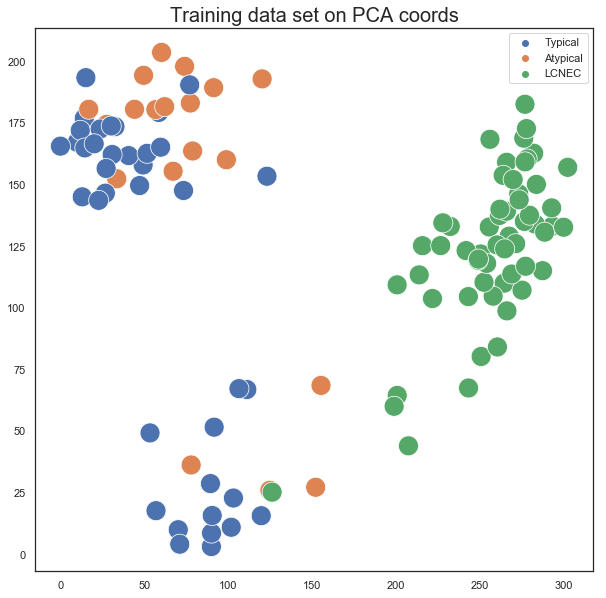

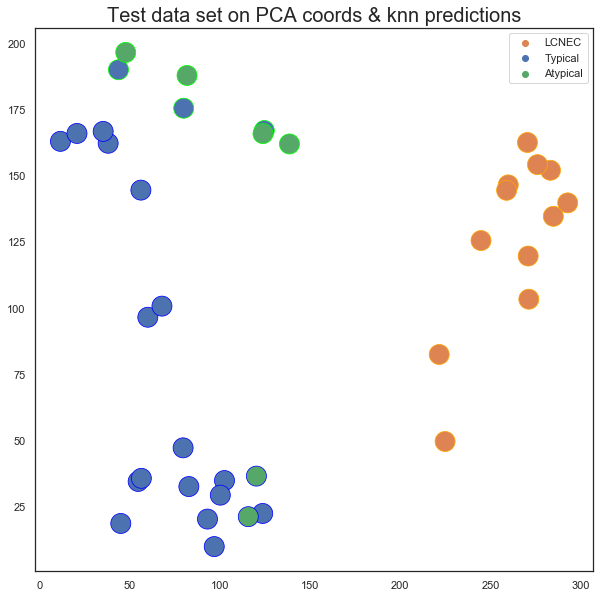

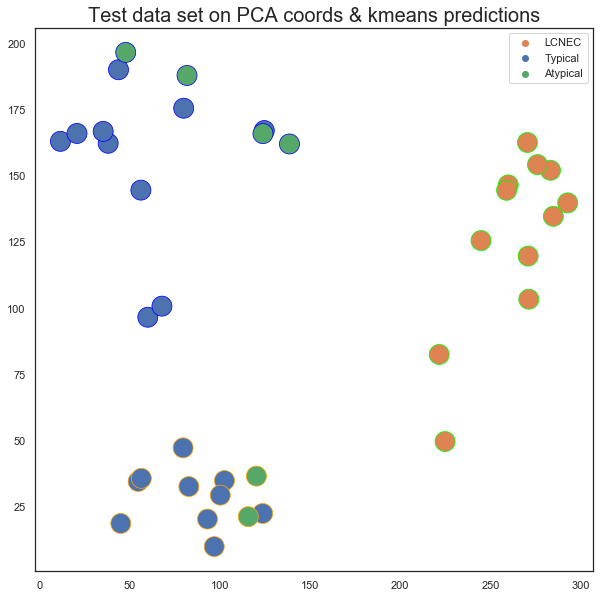

In [34]:
CV = train_test_split(coords_mofa_expr_lnen_m,lv_50_type,lv_50_type ) # Apprentissage à partir des coordonénes de la PCA
X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]


knn_pca = KNeighborsClassifier().fit(X_train, y_train)
svc_pca = SVC().fit(X_train, y_train)
kmeans_pca = KMeans(n_clusters=3).fit(X_train)


knn_pca.fit(X_train, y_train)
pred_knn_pca = knn_pca.predict(X_test)
pred_kmeans_pca = kmeans_pca.predict(X_test)
kmean_acc_pca , kmean_lab_pca =label_pred(y_test, pred_kmeans_pca)
print("Knn accurancy  : ",knn_pca.score(X_test, y_test))
print("SVC accurancy  : ",svc_pca.score(X_test, y_test))
print("Kmeans accurancy  : ", kmean_acc_pca)

edges_col = []
for i in pred_knn_pca:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

        
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(X_train[:, 0], X_train[:, 1],  hue=y_train ,s=400)
plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(X_test[:, 0], X_test[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.title("Test data set on PCA coords & knn predictions",  fontsize=20)
plt.show()


edges_col = []
for i in kmean_lab_pca:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(X_test[:, 0], X_test[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.title("Test data set on PCA coords & kmeans predictions",  fontsize=20)
plt.show()

#### PCA Autocorrélation spatiale

In [35]:
print(pysal.knnW(coords_mofa_expr_lnen_m, k = 7))
wknn7 = pysal.knnW(coords_mofa_expr_lnen_m, k = 7)

#print(type(spatial_attributes.iloc[:,1]))

OTP_gene_expression = np.array(spatial_attributes.iloc[:,0])
ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[:,1])
dendritic_cell = np.array(spatial_attributes.iloc[:,2])

mi_otp = pysal.Moran(OTP_gene_expression, wknn7 , two_tailed=True)
print(mi_otp.I)

mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn7 , two_tailed=True)
print(mi_angptl3.I)

mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn7 , two_tailed=True)
print(mi_dendritic_cell.I)
#help(pysal)

AttributeError: module 'pysal' has no attribute 'knnW'


These scores presents classifiers' accury (TP/(TP+FP)).
##### Unsupervised UMAP Preprocessing

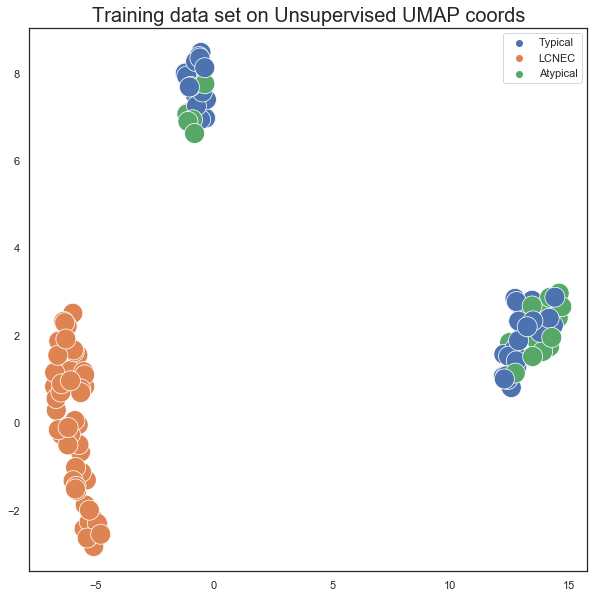

In [36]:
CV = train_test_split(coords_mofa_expr_lnen_m,lv_50_type,lv_50_type ) # Apprentissage à partir des coordonénes de la PCA
X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]

palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}
trans = umap.UMAP().fit(X_train)
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=trans.embedding_[:, 0], y=trans.embedding_[:, 1],  hue=y_train, palette =palette ,s=400)
plt.title("Training data set on Unsupervised UMAP coords",  fontsize=20)
plt.show()

In [37]:
svc_2 = SVC().fit(trans.embedding_, y_train)
knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
kmeans_2 = KMeans(n_clusters=3).fit(trans.embedding_, y_train)
test_embedding = trans.transform(X_test)
svc_pred_2= svc_2.predict(test_embedding)
knn_pred_2 = knn_2.predict(test_embedding)
kmeans_pred_2 = kmeans_2.predict(test_embedding)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**Graph for KNN prediction**

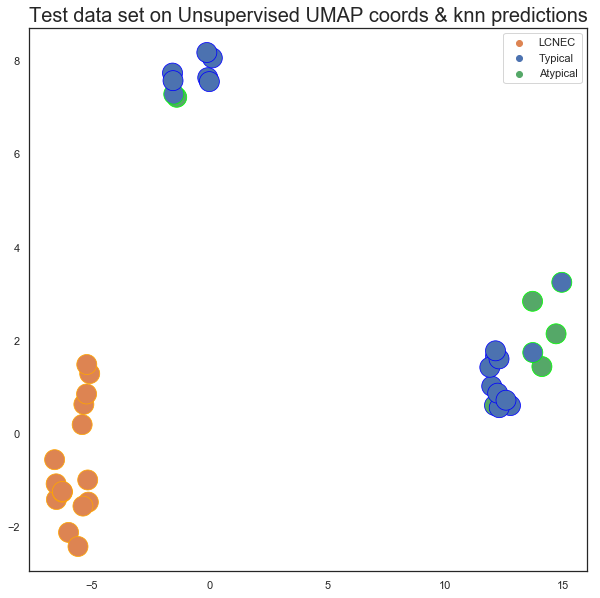

In [38]:
edges_col = []
for i in knn_pred_2:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_embedding[:, 0], test_embedding[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.title("Test data set on Unsupervised UMAP coords & knn predictions",  fontsize=20)
plt.show()


**Graph for Kmeans prediction**

In [39]:
kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )

pred_label   0   1  2
y_test               
Atypical     0   4  1
LCNEC       15   0  0
Typical      0  11  7
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.18421052631578946
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.18421052631578946
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.18421052631578946
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2894736842105263
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2894736842105263
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.2894736842105263
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}


In [40]:
edges_col = []
for i in kmean_lab_2:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

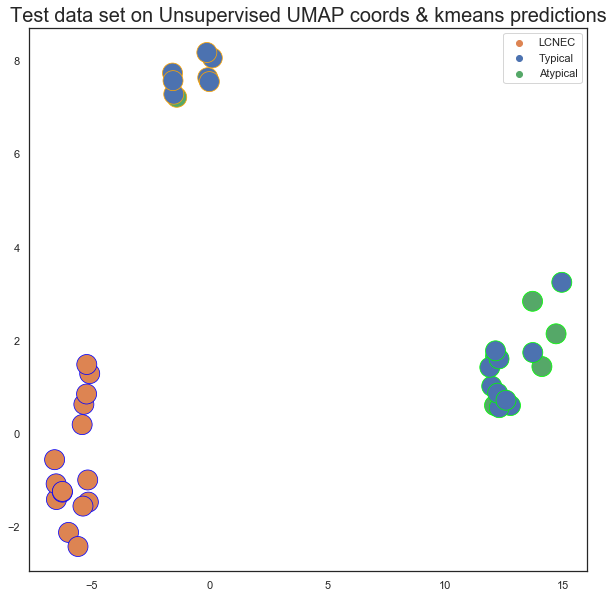

In [41]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_embedding[:, 0], test_embedding[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.title("Test data set on Unsupervised UMAP coords & kmeans predictions",  fontsize=20)
plt.show()

In [42]:
print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
print("Kmeans accurancy  : ",kmean_acc_2 )

Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.10526315789473684


In [43]:
print("Knn silhouette score  : ",silhouette_score(trans.transform(X_test), knn_pred_2) )
print("Svc silhouette score  : ",silhouette_score(trans.transform(X_test), svc_pred_2) )
print("Kmeans silhouette score  : ",silhouette_score(trans.transform(X_test), kmeans_pred_2) )

Knn silhouette score  :  0.34426647
Svc silhouette score  :  0.25258407
Kmeans silhouette score  :  0.86512023


### UMAP Unsupervised mean accuracy

In [64]:
knn_acc_umap_us =[]
svc_acc_umap_us =[]
kmeans_acc_umap_us =[]
otp_spatial_cor_umap_us =[]
angptl3_spatial_cor_umap_us =[]
dendritic_cells_spatial_cor_umap_us = []
for j  in range(10):
   
    CV = train_test_split(lv_50_data,lv_50_type,lv_50_type)
    
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
    trans = umap.UMAP().fit(X_train) 
    print("Y_TEST",y_test)
    print("Y_TEST",type(y_test))
    knn_umap_us = KNeighborsClassifier().fit(trans.embedding_, y_train)
    svc_umap_us = SVC().fit(trans.embedding_, y_train)
    kmeans_umap_us = KMeans(n_clusters=3).fit(trans.embedding_)
    
    test_embedding = trans.transform(X_test)
    svc_pred_umap_us= svc_umap_us.predict(test_embedding)
    knn_pred_umap_us = knn_umap_us.predict(test_embedding)
    kmeans_pred_umap_us = kmeans_umap_us.predict(test_embedding)
    
    kmean_acc_umap_us , kmean_lab_umap_us =label_pred(y_test, kmeans_pred_umap_us)
      
    print("Knn accurancy  : ",knn_umap_us.score(test_embedding, y_test))
    print("SVC accurancy  : ",svc_umap_us.score(test_embedding, y_test))
    print("Kmeans accurancy  : ", kmean_acc_umap_us)
    knn_acc_umap_us.append(knn_umap_us.score(test_embedding, y_test))  
    svc_acc_umap_us.append(svc_umap_us.score(test_embedding, y_test))
    kmeans_acc_umap_us.append(kmean_acc_umap_us)
    
    #print('X_train.index', type(X_train.index))

    wknn10 = pysal.knnW(test_embedding, k = 10)
    
    OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
    ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
    dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
    mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
    otp_spatial_cor_umap_us.append(mi_otp.I)


    mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
    angptl3_spatial_cor_umap_us.append(mi_angptl3.I)
 

    mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
    dendritic_cells_spatial_cor_umap_us.append(mi_dendritic_cell.I)


list_clustering=["knn_acc"]*10 + ["svc_acc"]*10 + ["kmeans_acc"]*10
Acc_val = knn_acc_umap_us +svc_acc_umap_us + kmeans_acc_umap_us

clustering_res_umap_us = pd.DataFrame() 
clustering_res_umap_us['clustering_method'] = list_clustering
clustering_res_umap_us['Acc_val'] = Acc_val
clustering_res_umap_us.shape


list_spatial_cor_umap_us = ["otp"]*10 + ["angptl3"]*10 + ["dendritic_cell"]*10
spatial_cor_val_umap_us = otp_spatial_cor_umap_us + angptl3_spatial_cor_umap_us + dendritic_cells_spatial_cor_umap_us
spatial_cor_umap_us = pd.DataFrame() 
spatial_cor_umap_us ['list_spatial_cor'] = list_spatial_cor_umap_us
spatial_cor_umap_us ['spatial_cor_val'] = spatial_cor_val_umap_us
spatial_cor_umap_us.shape

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_umap_us)
plt.title("Accurancy scores on UMAP unsupervised coords",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="list_spatial_cor", y="spatial_cor_val", data=spatial_cor_umap_us)
plt.title("Spatial corelation for umap unsupervised coords",  fontsize=20)
plt.show()


Y_TEST ['Typical', 'Atypical', 'Atypical', 'LCNEC', 'Atypical', 'LCNEC', 'Typical', 'Atypical', 'Typical', 'LCNEC', 'Typical', 'LCNEC', 'Typical', 'LCNEC', 'Typical', 'LCNEC', 'LCNEC', 'LCNEC', 'Atypical', 'Typical', 'LCNEC', 'LCNEC', 'Atypical', 'LCNEC', 'Typical', 'Typical', 'LCNEC', 'Typical', 'Atypical', 'LCNEC', 'Typical', 'LCNEC', 'Typical', 'Typical', 'LCNEC', 'LCNEC', 'Typical', 'LCNEC']
Y_TEST <class 'list'>
pred_label [2 2 2 1 2 1 2 0 2 1 0 1 2 1 2 1 1 1 2 2 1 1 2 1 0 2 1 0 2 1 2 1 2 2 1 1 0
 1]
y_test ['Typical', 'Atypical', 'Atypical', 'LCNEC', 'Atypical', 'LCNEC', 'Typical', 'Atypical', 'Typical', 'LCNEC', 'Typical', 'LCNEC', 'Typical', 'LCNEC', 'Typical', 'LCNEC', 'LCNEC', 'LCNEC', 'Atypical', 'Typical', 'LCNEC', 'LCNEC', 'Atypical', 'LCNEC', 'Typical', 'Typical', 'LCNEC', 'Typical', 'Atypical', 'LCNEC', 'Typical', 'LCNEC', 'Typical', 'Typical', 'LCNEC', 'LCNEC', 'Typical', 'LCNEC']
pred_label  0   1   2
y_test               
Atypical    1   0   6
LCNEC       0  17   0
Ty

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


AttributeError: module 'pysal' has no attribute 'knnW'

##### Supervised UMAP Preprocessing

In [ ]:
CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )

X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]



In [ ]:
y_train = list(y_train)
y_trainN  = []
for i in range(len(y_train)):
    if y_train[i]== 'Atypical':
        y_trainN.append(1)
    elif y_train[i]== 'Typical':
        y_trainN.append(2)
    elif y_train[i]== 'LCNEC':
        y_trainN.append(3)
    else :
        print("WARNING i = ", i)
        break

trans_sup = umap.UMAP().fit(X_train, y=y_trainN)

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=trans_sup.embedding_[:, 0], y=trans_sup.embedding_[:, 1],  hue=y_train ,s=400)
plt.title("Training data set on UMAP supervised coords",  fontsize=20)
plt.show()

In [ ]:
########################################@@####### A FINIR
#lv_50_type_df = pd.DataFrame(lv_50_type) 
#skf = StratifiedKFold(n_splits=5)
#for train_index, test_index in skf.split(lv_50_data, lv_50_type_df):
#       #print("TRAIN:", train_index, "TEST:", test_index)
#        X_train, X_test = lv_50_data.iloc[train_index,:], lv_50_data.iloc[test_index,:]
#        y_train, y_test = lv_50_type_df.iloc[train_index,:], lv_50_type_df.iloc[test_index,:]
        


In [ ]:
#type(lv_50_data)
#type(lv_50_type)

In [ ]:
svc_3 = SVC().fit(trans_sup.embedding_, y_train)
knn_3 = KNeighborsClassifier().fit(trans_sup.embedding_, y_train)
kmeans_3 = KMeans(n_clusters=3).fit(trans_sup.embedding_, y_train)
test_sup_embedding = trans_sup.transform(X_test)
svc_pred_3 = svc_3.predict(test_sup_embedding)
knn_pred_3 = knn_3.predict(test_sup_embedding)
kmeans_pred_3 = kmeans_3.predict(test_sup_embedding)
kmean_acc_umap_s , kmean_lab_umap_s =label_pred(y_test, kmeans_pred_3)

In [ ]:
edges_col_2 = []
for i in knn_pred_3:
    if i == "Typical":
        edges_col_2.append("orange")
    elif i == "LCNEC":
        edges_col_2.append("blue")
    elif i == "Atypical":
        edges_col_2.append("lime")
    else :
        print("warning")

In [ ]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_sup_embedding[:, 0], test_sup_embedding[:, 1],  hue=y_test, edgecolor=edges_col_2 ,s=400)
plt.title("Test data set on supervised UMAP coords & Knn predictions",  fontsize=20)
plt.show()

In [ ]:
kmean_acc_umap_s , kmean_lab_umap_s =label_pred(y_test, kmeans_pred_3)

In [ ]:
edges_col_3 = []
for i in kmean_lab_umap_s:
    if i == "Typical":
        edges_col_3.append("lime")
    elif i == "LCNEC":
        edges_col_3.append("blue")
    elif i == "Atypical":
        edges_col_3.append("orange")
    else :
        print("warning")

In [ ]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_sup_embedding[:, 0], test_sup_embedding[:, 1],  hue=y_test, edgecolor=edges_col_3 ,s=400)
plt.title("Test data set on supervised UMAP coords & Kmeans predictions",  fontsize=20)
plt.show()

In [ ]:
print("Knn accurancy  : ",knn_3.score(trans_sup.transform(X_test), y_test) )
print("SVC accurancy  : ",svc_3.score(trans_sup.transform(X_test), y_test) )
print("Kmeans accurancy  : ", kmean_acc_umap_s)

In [ ]:
print("Knn silhouette score  : ",silhouette_score(trans_sup.transform(X_test), knn_pred_3) )
print("Svc silhouette score  : ",silhouette_score(trans_sup.transform(X_test), svc_pred_3) )
print("Kmeans silhouette score  : ",silhouette_score(trans_sup.transform(X_test), kmeans_pred_3) )

In [ ]:
knn_acc_umap_s =[]
svc_acc_umap_s =[]
kmeans_acc_umap_s =[]
otp_spatial_cor_umap_s =[]
angptl3_spatial_cor_umap_s =[]
dendritic_cells_spatial_cor_umap_s = []
for j  in range(10):
   
    CV = train_test_split(lv_50_data,lv_50_type,lv_50_type)
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
    
    y_train = list(y_train)
    y_trainN  = []
    for i in range(len(y_train)):
        if y_train[i]== 'Atypical':
            y_trainN.append(1)
        elif y_train[i]== 'Typical':
            y_trainN.append(2)
        elif y_train[i]== 'LCNEC':
            y_trainN.append(3)
        else :
            print("WARNING i = ", i)

    trans = umap.UMAP().fit(X_train, y=y_trainN)
    
    knn_umap_s = KNeighborsClassifier().fit(trans.embedding_, y_train)
    svc_umap_s = SVC().fit(trans.embedding_, y_train)
    kmeans_umap_s = KMeans(n_clusters=3).fit(trans.embedding_)
    
    test_embedding = trans.transform(X_test)
    svc_pred_umap_s= svc_umap_s.predict(test_embedding)
    knn_pred_umap_s = knn_umap_s.predict(test_embedding)
    kmeans_pred_umap_s = kmeans_umap_s.predict(test_embedding)
    
    kmean_acc_umap_s , kmean_lab_umap_s =label_pred(y_test, kmeans_pred_umap_s)
      
    print("Knn accurancy  : ",knn_umap_s.score(test_embedding, y_test))
    print("SVC accurancy  : ",svc_umap_s.score(test_embedding, y_test))
    print("Kmeans accurancy  : ", kmean_acc_umap_s)
    knn_acc_umap_s.append(knn_umap_s.score(test_embedding, y_test))  
    svc_acc_umap_s.append(svc_umap_s.score(test_embedding, y_test))
    kmeans_acc_umap_s.append(kmean_acc_umap_s)

    
    wknn10 = pysal.knnW(test_embedding, k = 10)
    
    OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
    ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
    dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
    mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
    otp_spatial_cor_umap_s.append(mi_otp.I)


    mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
    angptl3_spatial_cor_umap_s.append(mi_angptl3.I)
 

    mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
    dendritic_cells_spatial_cor_umap_s.append(mi_dendritic_cell.I)



list_clustering=["knn_acc"]*10 + ["svc_acc"]*10 + ["kmeans_acc"]*10
Acc_val = knn_acc_umap_s + svc_acc_umap_s + kmeans_acc_umap_s

clustering_res_umap_s = pd.DataFrame() 
clustering_res_umap_s['clustering_method'] = list_clustering
clustering_res_umap_s['Acc_val'] = Acc_val
clustering_res_umap_s.shape


list_spatial_cor_umap_s = ["otp"]*10 + ["angptl3"]*10 + ["dendritic_cell"]*10
spatial_cor_val_umap_s = otp_spatial_cor_umap_s + angptl3_spatial_cor_umap_s + dendritic_cells_spatial_cor_umap_s
spatial_cor_umap_s = pd.DataFrame() 
spatial_cor_umap_s ['list_spatial_cor'] = list_spatial_cor_umap_s
spatial_cor_umap_s ['spatial_cor_val'] = spatial_cor_val_umap_s
spatial_cor_umap_s.shape

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_umap_s)
plt.title("Accurancy scores on supervised UMAP coords",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="list_spatial_cor", y="spatial_cor_val", data=spatial_cor_umap_s)
plt.title("Spatial corelation for umap supervised coords",  fontsize=20)
plt.show()



# Min dist

In [ ]:
min_dist_test = [0,0.5,1]

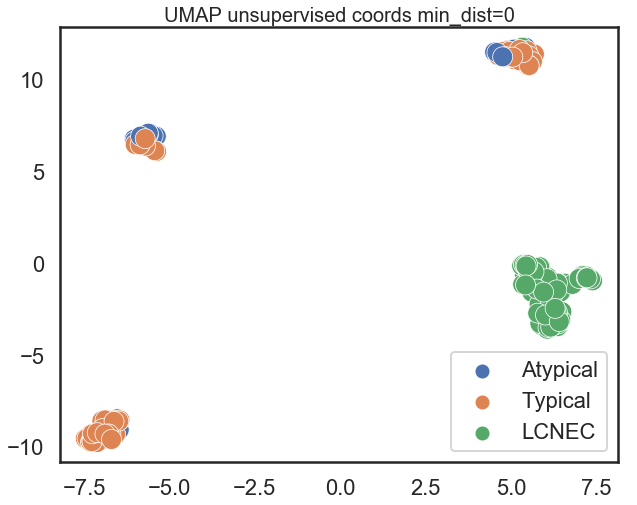

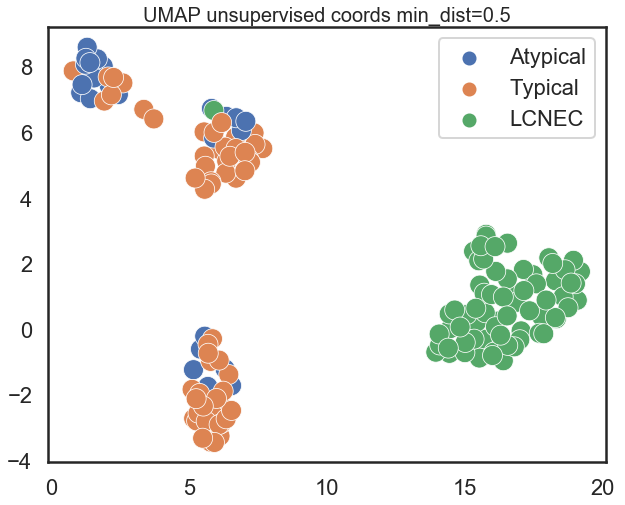

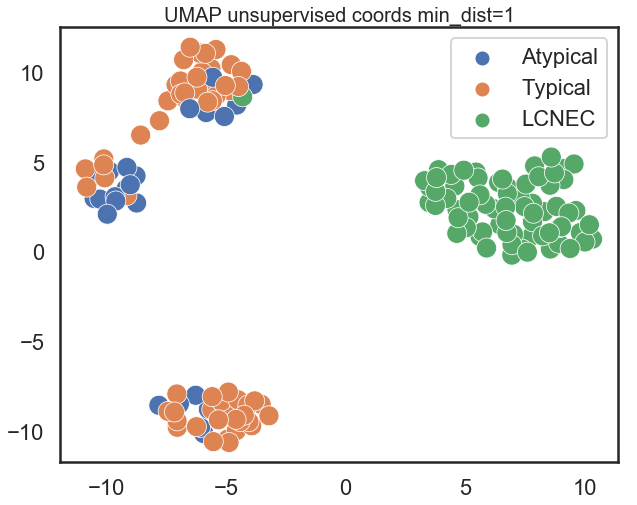

In [59]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_0 = umap.UMAP(min_dist=0).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_0[:, 0], y=standard_embedding_0[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0.5).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0.5",  fontsize=20)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=1).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=1",  fontsize=20)
plt.show()

**The default value for min_dist (as used above) is 0.1. We will look at a range of values from 0.0 through to 0.99.**

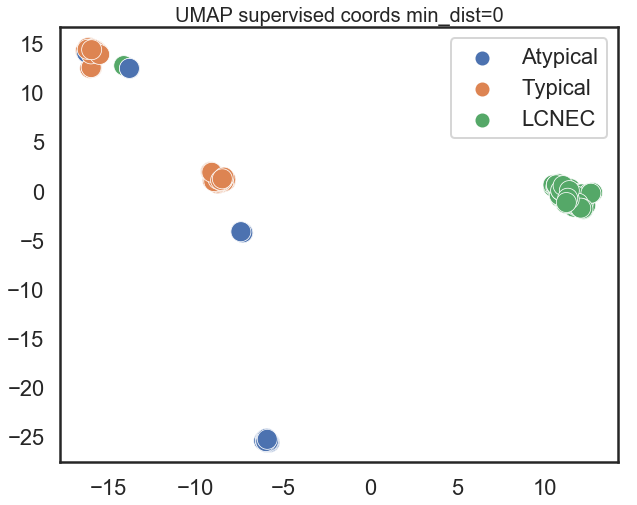

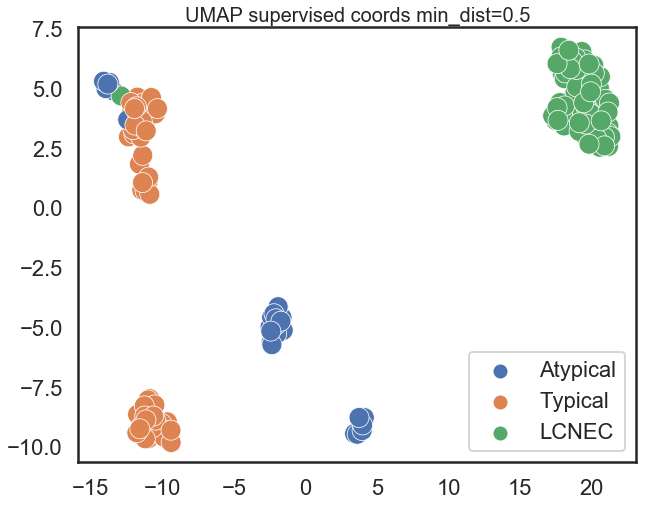

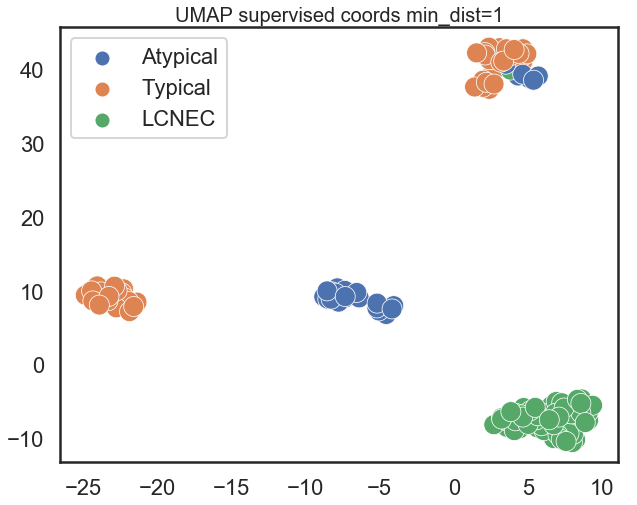

In [60]:
embedding_MD_0 = umap.UMAP(min_dist=0).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
sns.scatterplot(x=embedding_MD_0[:, 0], y=embedding_MD_0[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP supervised coords min_dist=0",  fontsize=20)
plt.show()

embedding_MD_05 = umap.UMAP(min_dist=0.5).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
sns.scatterplot(x=embedding_MD_05[:, 0], y=embedding_MD_05[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP supervised coords min_dist=0.5",  fontsize=20)
plt.show()

embedding_MD_1 = umap.UMAP(min_dist=1).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
sns.scatterplot(x=embedding_MD_1[:, 0], y=embedding_MD_1[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP supervised coords min_dist=1",  fontsize=20)
plt.show()

## Neighborhood preservation

### Distance

In [61]:
standard_embedding_0_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_0_df['X'] = standard_embedding_0[:,0]
standard_embedding_0_df['Y'] = standard_embedding_0[:,1]

standard_embedding_05_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_05_df['X'] = standard_embedding_05[:,0]
standard_embedding_05_df['Y'] = standard_embedding_05[:,1]

standard_embedding_1_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_1_df['X'] = standard_embedding_1[:,0]
standard_embedding_1_df['Y'] = standard_embedding_1[:,1]

d_umap_md_0 =  Neighborhood.distance_matrix(standard_embedding_0_df)
d_umap_md_05 =  Neighborhood.distance_matrix(standard_embedding_05_df)
d_umap_md_1 =  Neighborhood.distance_matrix(standard_embedding_1_df)


d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn

In [62]:
coords_mofa_expr_lnen.head()
Sample_ID_df =pd.DataFrame(data_lv_50_type3["Sample_ID"] )
coords_mofa_expr_lnen_v2 = pd.merge(coords_mofa_expr_lnen, Sample_ID_df, on='Sample_ID', how='inner')
coords_mofa_expr_lnen = coords_mofa_expr_lnen_v2

## Writing

In [63]:
#standard_embedding_0_df.to_csv(path_or_buf='umap_md_0_coord.txt', sep='\t')
#standard_embedding_05_df.to_csv(path_or_buf='umap_md_05_coord.txt', sep='\t')
#standard_embedding_1_df.to_csv(path_or_buf='umap_md_1_coord.txt', sep='\t')

# CP

In [64]:
# cp0 = Neighborhood.centrality_preservation(d_umap_md_0 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),10),"CP_pulmo_R_UMAP_MD0")
#cp05 = Neighborhood.centrality_preservation(d_umap_md_05 ,  Dist_pulmonary , range(1,len(standard_embedding_05[:,0]),10),"CP_pulmo_R_UMAP_MD05")
#cp1 = Neighborhood.centrality_preservation(d_umap_md_1 ,  Dist_pulmonary , range(1,len(standard_embedding_1[:,0]),10),"CP_pulmo_R_UMAP_MD1")


![CPMinDist](cp_min_dist_v2.png)

# Seq Set

In [65]:
#Neighborhood.main_f(d_umap_md_0 , Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_R_UMAP_MD0" , "seq_diff_pulmo_R_UMAP_MD0" , True )
#Neighborhood.main_f(d_umap_md_05, Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_R_UMAP_MD05" , "seq_diff_pulmo_R_UMAP_MD05" , True )
#Neighborhood.main_f(d_umap_md_1, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_UMAP_MD1" , "seq_diff_pulmo_R_UMAP_MD1" , True )

In [66]:
#Neighborhood.main_f(d_umap_md_1, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_UMAP_MD1" , "seq_diff_pulmo_R_UMAP_MD1" , True )

![set_diff_min_dist_v2](set_diff_min_dist_v2.png)

![seq_diff_v2](seq_diff_v2.png)
![seq_diff_min_dist_log](seq_diff_min_dist_log.png)

## Clustering

In [79]:
min_dist_test = [0,0.5,1,2.5]
knn_acc_no_prepro =[]
svc_acc_no_prepro =[]
kmeans_acc_no_prepro =[]
for j  in range(5):
    CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
    
    #print('y_test',  y_test)
    #print(' y_test.shape',  y_test.shape)
    #print('type( y_test)', type( y_test))
        
    knn_1 = KNeighborsClassifier().fit(X_train, y_train)
    svc_1 = SVC().fit(X_train, y_train)
    kmeans_1 = KMeans(n_clusters=3).fit(X_train)
    knn_1.fit(X_train, y_train)
    pred_knn_1 = knn_1.predict(X_test)
    pred_kmeans_1 = kmeans_1.predict(X_test)
    kmean_acc_1 , kmean_lab_1 =label_pred(y_test, pred_kmeans_1 )
    
    
    print("Knn accurancy  : ",knn_1.score(X_test, y_test))
    print("SVC accurancy  : ",svc_1.score(X_test, y_test))
    print("Kmeans accurancy  : ", kmean_acc_1)
    knn_acc_no_prepro.append(knn_1.score(X_test, y_test))  
    svc_acc_no_prepro.append(svc_1.score(X_test, y_test))
    kmeans_acc_no_prepro.append(kmean_acc_1)
        
        

y_test 123     Typical
99      Typical
73        LCNEC
75      Typical
24      Typical
146     Typical
143     Typical
84      Typical
2      Atypical
90      Typical
53        LCNEC
147       LCNEC
1      Atypical
28        LCNEC
89      Typical
72        LCNEC
8      Atypical
87      Typical
77        LCNEC
145     Typical
31        LCNEC
47        LCNEC
19      Typical
5      Atypical
61        LCNEC
151    Atypical
85     Atypical
108       LCNEC
105    Atypical
132       LCNEC
4      Atypical
100     Typical
6      Atypical
9      Atypical
142     Typical
80        LCNEC
118     Typical
57        LCNEC
Name: Histpopathology_4_classes, dtype: object
 y_test.shape (38,)
type( y_test) <class 'pandas.core.series.Series'>


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  4
LCNEC       13  0  0
Typical      0  8  7
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.18421052631578946
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.18421052631578946
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.18421052631578946
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.21052631578947367
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.21052631578947367
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.21052631578947367
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.6842105263157895
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
c 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    0   0  7
LCNEC       1  15  0
Typical     7   0  8
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.6052631578947368
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.6052631578947368
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.6052631578947368
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.0
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.0
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.0
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.23684210526315788
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.23684210526315788
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.23684210526315788
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
c acc_score 0.18421052631578946
c_dict {1: 'Atypic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  3
LCNEC       0  18  0
Typical     6   0  9
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.05263157894736842
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.05263157894736842
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.05263157894736842
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.23684210526315788
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.23684210526315788
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.23684210526315788
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
c 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  2
LCNEC       0  21  0
Typical     7   0  6
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.05263157894736842
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.05263157894736842
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.05263157894736842
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.15789473684210525
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.15789473684210525
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.15789473684210525
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
c 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    1   0   4
LCNEC       1  16   0
Typical     4   0  12
P [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
original_labels ['Atypical', 'LCNEC', 'Typical']
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
c acc_score 0.7631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.02631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.02631578947368421
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
c acc_score 0.02631578947368421
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.34210526315789475
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.34210526315789475
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
c acc_score 0.34210526315789475
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical

In [68]:
list_clustering=["knn_acc"]*5 + ["svc_acc"]*5 + ["kmeans_acc"]*5
Acc_val = knn_acc_no_prepro + svc_acc_no_prepro + kmeans_acc_no_prepro

clustering_res_no_preprocessing = pd.DataFrame() 
clustering_res_no_preprocessing['clustering_method'] = list_clustering
clustering_res_no_preprocessing['Acc_val'] = Acc_val
clustering_res_no_preprocessing.shape

(15, 2)

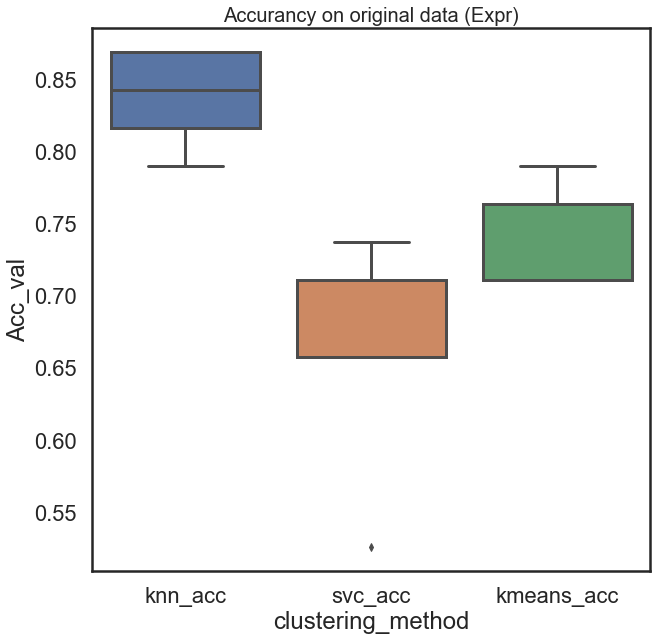

In [69]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_no_preprocessing)
plt.title("Accurancy on original data (Expr)",  fontsize=20)
plt.show()

In [70]:
min_dist_test = [0,0.5,1]
min_dist = []
knn_acc = []
kmeans_acc = []
svc_acc = []

knn_silh = []
kmeans_silh = []
svc_silh = []



otp_spatial_cor_umap_md =[]
angptl3_spatial_cor_umap_md =[]
dendritic_cells_spatial_cor_umap_md = []

for i in min_dist_test :
    print('\n')
    print('i', i)
    for j  in range(5):
        CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
        X_train = CV[0]
        X_test = CV[1]
        y_train = CV[2]
        y_test = CV[3]
        
        trans = umap.UMAP(min_dist = i).fit(X_train)
        svc_2 = SVC().fit(trans.embedding_, y_train)
        knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
        kmeans_2 = KMeans(n_clusters=3).fit(trans.embedding_, y_train)
        
        test_embedding = trans.transform(X_test)
        svc_pred_2= svc_2.predict(test_embedding)
        knn_pred_2 = knn_2.predict(test_embedding)
        kmeans_pred_2 = kmeans_2.predict(test_embedding)
        
        kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )
        
        print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
        print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
        print("Kmeans accurancy  : ",kmean_acc_2 )
        
        print("Knn silhouette score  : ",silhouette_score(trans.transform(X_test), knn_pred_2) )
        print("Svc silhouette score  : ",silhouette_score(trans.transform(X_test), svc_pred_2) )
        print("Kmeans silhouette score  : ",silhouette_score(trans.transform(X_test), kmeans_pred_2) )
        
        min_dist.append(i)
        knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
        svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
        kmeans_acc.append(kmean_acc_2)
        
        knn_silh.append(silhouette_score(trans.transform(X_test), knn_pred_2))
        svc_silh.append(silhouette_score(trans.transform(X_test), svc_pred_2))
        kmeans_silh.append(silhouette_score(trans.transform(X_test), kmeans_pred_2))
       
        wknn10 = pysal.knnW(test_embedding, k = 10)
    
        OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
        ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
        dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
        mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
        otp_spatial_cor_umap_md.append(mi_otp.I)


        mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
        angptl3_spatial_cor_umap_md.append(mi_angptl3.I)
 

        mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
        dendritic_cells_spatial_cor_umap_md.append(mi_dendritic_cell.I)
    
    
    

        



i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  2
LCNEC       0  15  1
Typical     8   0  8
acc_score [0.7105263157894737, 0.13157894736842105, 0.21052631578947367, 0.23684210526315788, 0.05263157894736842, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.4823607
Svc silhouette score  :  0.60314196
Kmeans silhouette score  :  0.87710744


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  0
LCNEC       15  0  0
Typical      0  9  8
acc_score [0.21052631578947367, 0.23684210526315788, 0.7631578947368421, 0.15789473684210525, 0.631578947368421, 0.0]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.52756095
Svc silhouette score  :  0.61667484
Kmeans silhouette score  :  0.81171244


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    1   0  3
LCNEC       0  17  0
Typical     8   0  9
acc_score [0.7105263157894737, 0.02631578947368421, 0.23684210526315788, 0.21052631578947367, 0.07894736842105263, 0.7368421052631579]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.53415483
Svc silhouette score  :  0.5817873
Kmeans silhouette score  :  0.7903699


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    1   0   3
LCNEC       0  14   0
Typical     6   0  14
acc_score [0.7631578947368421, 0.02631578947368421, 0.3684210526315789, 0.15789473684210525, 0.07894736842105263, 0.6052631578947368]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.22785942
Svc silhouette score  :  0.27210617
Kmeans silhouette score  :  0.9021938


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1   2
y_test              
Atypical    1  5   0
LCNEC       0  0  19
Typical     6  7   0
acc_score [0.02631578947368421, 0.7105263157894737, 0.13157894736842105, 0.7894736842105263, 0.18421052631578946, 0.15789473684210525]
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.4253499
Svc silhouette score  :  0.63775134
Kmeans silhouette score  :  0.8603714


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     2   0  0
LCNEC        0  18  1
Typical     10   0  7
acc_score [0.7105263157894737, 0.07894736842105263, 0.18421052631578946, 0.2894736842105263, 0.0, 0.7368421052631579]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.45290273
Svc silhouette score  :  0.45780754
Kmeans silhouette score  :  0.7820573


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     2  0   0
LCNEC        1  0  19
Typical     10  6   0
acc_score [0.05263157894736842, 0.7105263157894737, 0.02631578947368421, 0.7631578947368421, 0.18421052631578946, 0.2631578947368421]
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.53105557
Svc silhouette score  :  0.72067404
Kmeans silhouette score  :  0.7579544


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    6   0  4
LCNEC       0  16  0
Typical     6   0  6
acc_score [0.7368421052631579, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.10526315789473684, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.7631578947368421
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.46280736
Svc silhouette score  :  0.3011202
Kmeans silhouette score  :  0.8365564


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  4  4
LCNEC       15  0  0
Typical      0  8  7
acc_score [0.18421052631578946, 0.21052631578947367, 0.6842105263157895, 0.10526315789473684, 0.7105263157894737, 0.10526315789473684]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.4136193
Svc silhouette score  :  0.4136193
Kmeans silhouette score  :  0.59232026


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  5  1
LCNEC       22  0  0
Typical      0  6  4
acc_score [0.10526315789473684, 0.15789473684210525, 0.8157894736842105, 0.13157894736842105, 0.7631578947368421, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.5834059
Svc silhouette score  :  0.48476133
Kmeans silhouette score  :  0.826778


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  3  3
LCNEC       17  1  0
Typical      0  9  5
acc_score [0.15789473684210525, 0.23684210526315788, 0.6578947368421053, 0.07894736842105263, 0.7631578947368421, 0.10526315789473684]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.40272546
Svc silhouette score  :  0.41054034
Kmeans silhouette score  :  0.743985


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  4
LCNEC       1  18  0
Typical     3   0  8
acc_score [0.7894736842105263, 0.10526315789473684, 0.23684210526315788, 0.07894736842105263, 0.13157894736842105, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.6031701
Svc silhouette score  :  0.5515982
Kmeans silhouette score  :  0.8735212


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  5  3
LCNEC       19  0  0
Typical      0  6  5
acc_score [0.13157894736842105, 0.15789473684210525, 0.7631578947368421, 0.13157894736842105, 0.7368421052631579, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.5655364
Svc silhouette score  :  0.5655364
Kmeans silhouette score  :  0.74356526


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  2
LCNEC       1  19  0
Typical     7   0  5
acc_score [0.7368421052631579, 0.10526315789473684, 0.15789473684210525, 0.18421052631578946, 0.07894736842105263, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.56267184
Svc silhouette score  :  0.5102662
Kmeans silhouette score  :  0.8204861


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     2  0  2
LCNEC       21  0  0
Typical      7  5  1
acc_score [0.07894736842105263, 0.18421052631578946, 0.5789473684210527, 0.18421052631578946, 0.7368421052631579, 0.23684210526315788]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.43608594
Svc silhouette score  :  0.367435
Kmeans silhouette score  :  0.6828404


In [71]:
list_clustering=["knn_acc"]*len(knn_acc) + ["svc_acc"]*len(knn_acc) + ["kmeans_acc"]*len(knn_acc)
Acc_val = knn_acc + svc_acc + kmeans_acc
Sihl_val = knn_silh + svc_silh+ kmeans_silh
Min_dist_val = min_dist + min_dist + min_dist

In [72]:
clustering_res = pd.DataFrame() 
clustering_res['clustering_method'] = list_clustering
clustering_res['Acc_val'] = Acc_val
clustering_res['Silh_val'] = Sihl_val
clustering_res['min_dist'] = Min_dist_val
#clustering_res.shape
#clustering_res.head

In [73]:
list_spatial_cor_umap_md = ["otp"]*len(otp_spatial_cor_umap_md) + ["angptl3"]*len(otp_spatial_cor_umap_md) + ["dendritic_cell"]*len(otp_spatial_cor_umap_md)
spatial_cor_val_umap_md = otp_spatial_cor_umap_md + angptl3_spatial_cor_umap_md + dendritic_cells_spatial_cor_umap_md
spatial_cor_umap_md = pd.DataFrame() 
spatial_cor_umap_md['list_spatial_cor'] = list_spatial_cor_umap_md
spatial_cor_umap_md ['spatial_cor_val'] = spatial_cor_val_umap_md
spatial_cor_umap_md ['min_dist'] =Min_dist_val
spatial_cor_umap_md.shape



(45, 3)

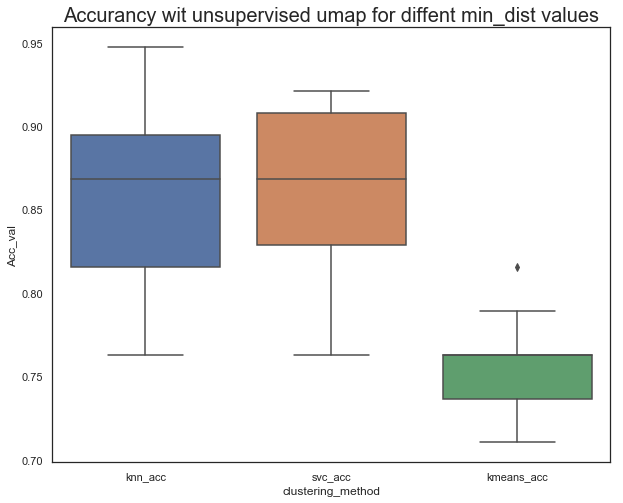

In [74]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res)
plt.title("Accurancy wit unsupervised umap for diffent min_dist values",  fontsize=20)
plt.show()

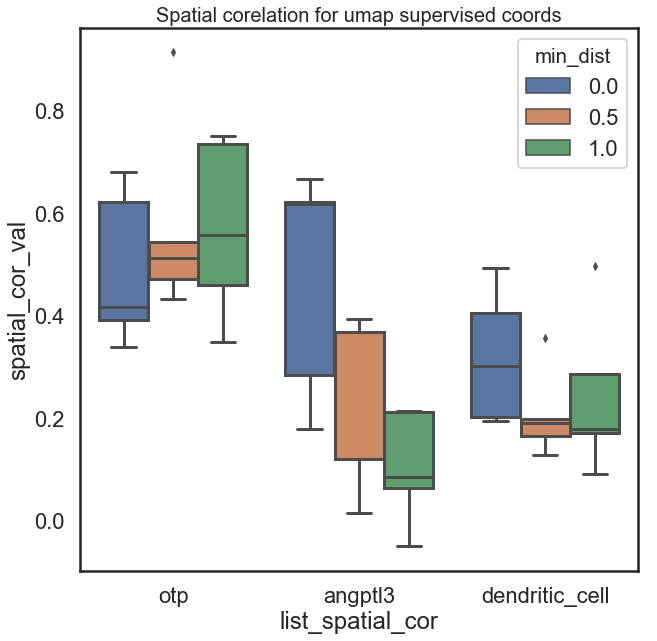

In [75]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="list_spatial_cor", y="spatial_cor_val", hue="min_dist",data=spatial_cor_umap_md)
plt.title("Spatial corelation for umap supervised coords",  fontsize=20)
plt.show()

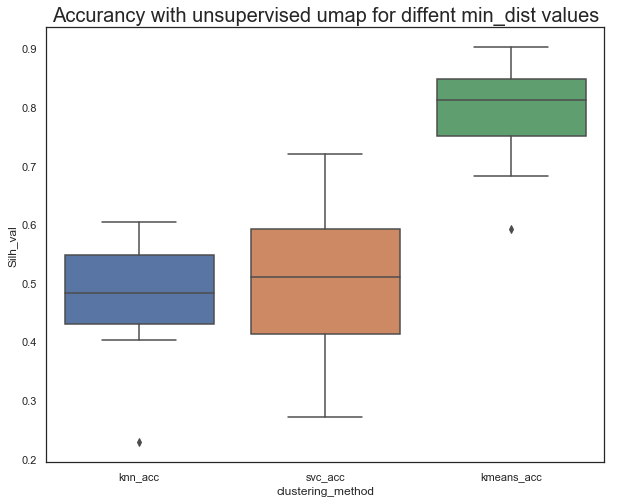

In [76]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.boxplot(x="clustering_method", y="Silh_val", data=clustering_res)
plt.title("Accurancy with unsupervised umap for diffent min_dist values",  fontsize=20)
plt.show()

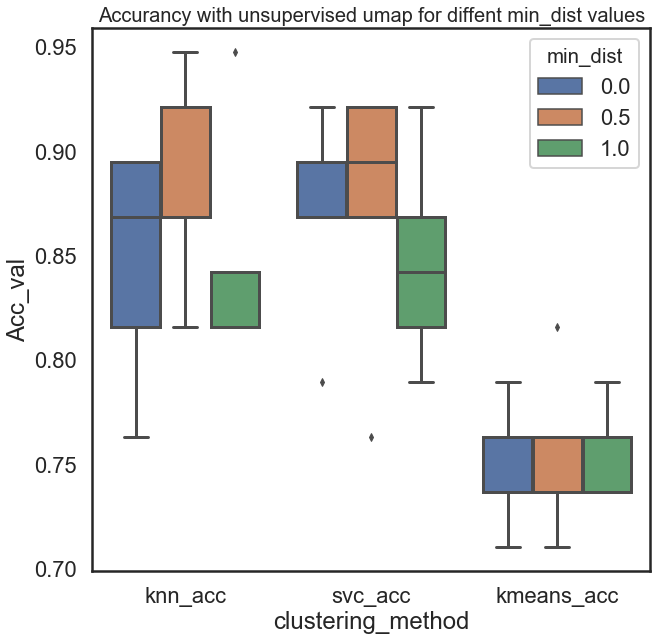

In [77]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", hue="min_dist", data=clustering_res)
plt.title("Accurancy with unsupervised umap for diffent min_dist values",  fontsize=20)
plt.show()

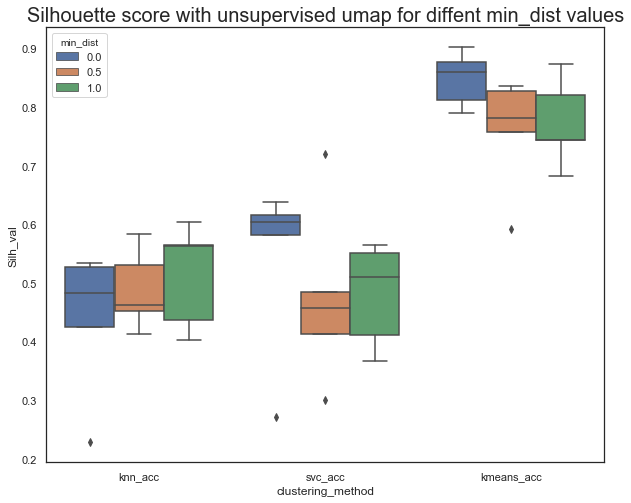

In [78]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.boxplot(x="clustering_method", y="Silh_val", hue="min_dist", data=clustering_res)
plt.title("Silhouette score with unsupervised umap for diffent min_dist values",  fontsize=20)
plt.show()

# Min dist + N_neighbors

In [79]:
min_dist_test = [0,0.5,1]
n_neighbors_test  = [2, 10,50,100 ]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 25 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


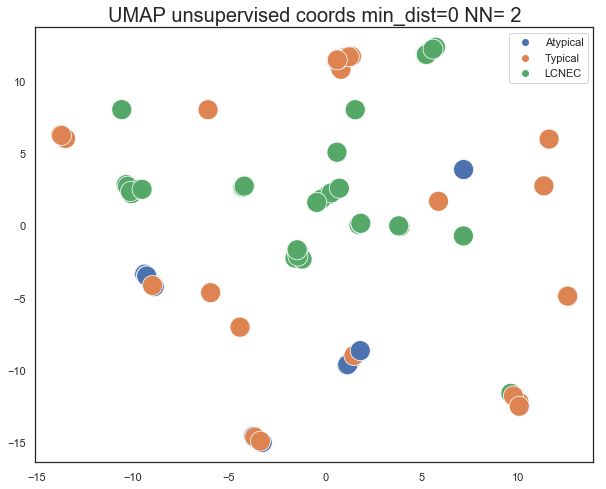

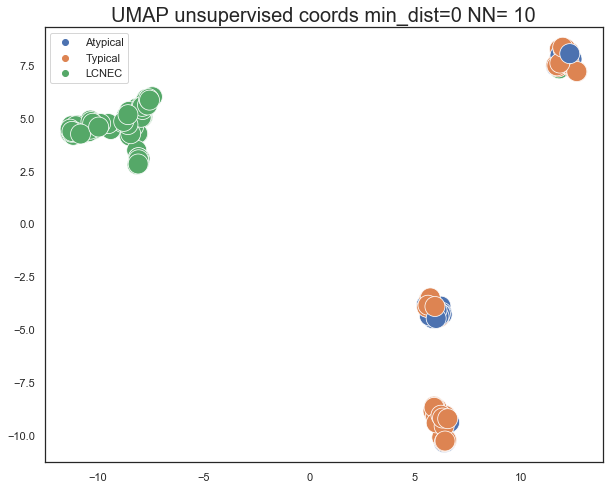

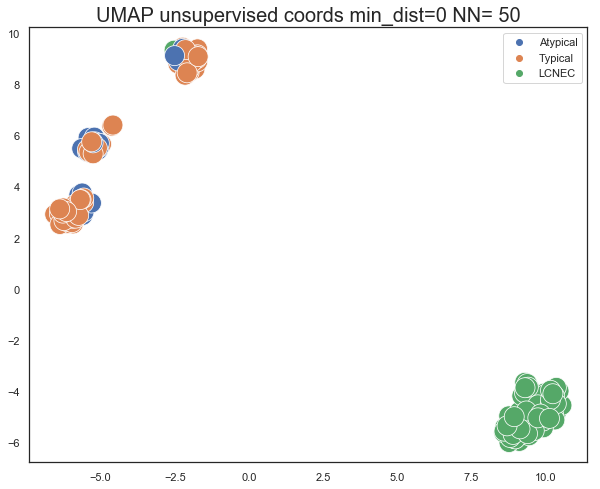

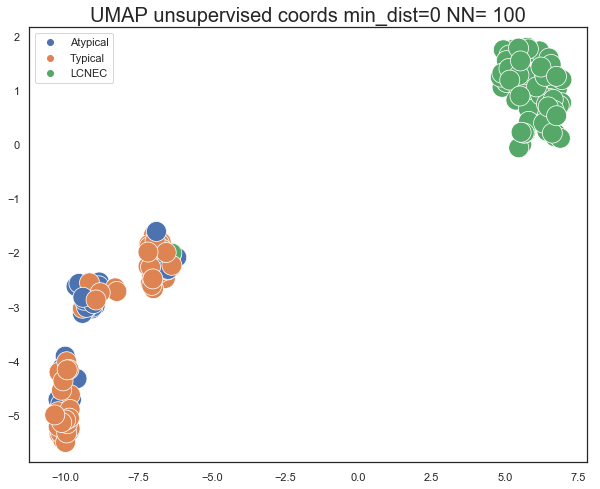

In [80]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_0 = umap.UMAP(min_dist=0, n_neighbors = 2).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_0[:, 0], y=standard_embedding_0[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0 NN= 2",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0,  n_neighbors = 10).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0 NN= 10",  fontsize=20)
plt.show()

sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=0,  n_neighbors = 50).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0 NN= 50",  fontsize=20)
plt.show()

sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=0,  n_neighbors = 100).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0 NN= 100",  fontsize=20)
plt.show()

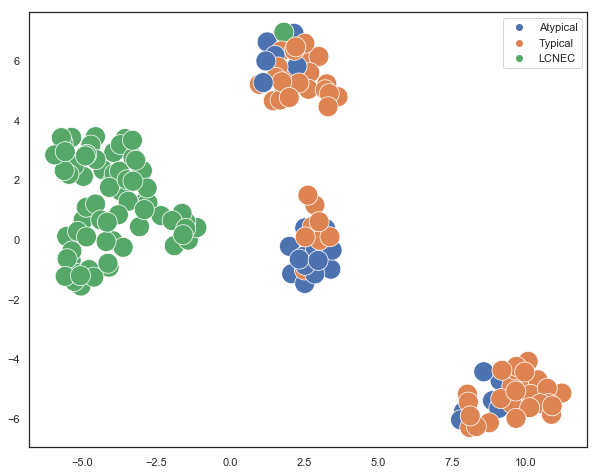

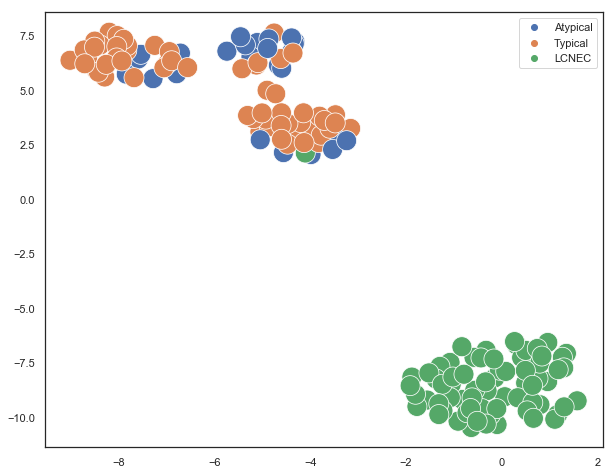

In [81]:
lv_50_data = data_lv_50_type3.iloc[:,1:6398]

sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0.5,  n_neighbors = 10).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=0.5,  n_neighbors = 50).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.show()

## Neighborhood preservation

### Distance

In [82]:

embedding_MD_0_NN2 = umap.UMAP(min_dist=0, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN10 = umap.UMAP(min_dist=0, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN50 = umap.UMAP(min_dist=0, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN100 = umap.UMAP(min_dist=0, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

embedding_MD_05_NN2 = umap.UMAP(min_dist=0.5, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN10 = umap.UMAP(min_dist=0.5, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN50 = umap.UMAP(min_dist=0.5, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN100 = umap.UMAP(min_dist=0.5, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

embedding_MD_1_NN2 = umap.UMAP(min_dist=1, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN10 = umap.UMAP(min_dist=1, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN50 = umap.UMAP(min_dist=1, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN100 = umap.UMAP(min_dist=1, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

###
embedding_MD_0_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN2_df['X'] = embedding_MD_0_NN2[:,0]
embedding_MD_0_NN2_df['Y'] = embedding_MD_0_NN2[:,1]

embedding_MD_0_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN10_df['X'] = embedding_MD_0_NN10[:,0]
embedding_MD_0_NN10_df['Y'] = embedding_MD_0_NN10[:,1]

embedding_MD_0_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN50_df['X'] = embedding_MD_0_NN50[:,0]
embedding_MD_0_NN50_df['Y'] = embedding_MD_0_NN50[:,1]

embedding_MD_0_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN100_df['X'] = embedding_MD_0_NN100[:,0]
embedding_MD_0_NN100_df['Y'] = embedding_MD_0_NN100[:,1]


d_umap_md_0_nn2 =  Neighborhood.distance_matrix(embedding_MD_0_NN2_df)
d_umap_md_0_nn10 =  Neighborhood.distance_matrix(embedding_MD_0_NN10_df)
d_umap_md_0_nn50 =  Neighborhood.distance_matrix(embedding_MD_0_NN50_df)
d_umap_md_0_nn100 =  Neighborhood.distance_matrix(embedding_MD_0_NN100_df)


##


embedding_MD_05_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN2_df['X'] = embedding_MD_05_NN2[:,0]
embedding_MD_05_NN2_df['Y'] = embedding_MD_05_NN2[:,1]

embedding_MD_05_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN10_df['X'] = embedding_MD_05_NN10[:,0]
embedding_MD_05_NN10_df['Y'] = embedding_MD_05_NN10[:,1]

embedding_MD_05_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN50_df['X'] = embedding_MD_05_NN50[:,0]
embedding_MD_05_NN50_df['Y'] = embedding_MD_05_NN50[:,1]

embedding_MD_05_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN100_df['X'] = embedding_MD_05_NN100[:,0]
embedding_MD_05_NN100_df['Y'] = embedding_MD_05_NN100[:,1]

d_umap_md_05_nn2 =  Neighborhood.distance_matrix(embedding_MD_05_NN2_df)
d_umap_md_05_nn10 =  Neighborhood.distance_matrix(embedding_MD_05_NN10_df)
d_umap_md_05_nn50 =  Neighborhood.distance_matrix(embedding_MD_05_NN50_df)
d_umap_md_05_nn100 =  Neighborhood.distance_matrix(embedding_MD_05_NN100_df)

####

embedding_MD_1_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN2_df['X'] = embedding_MD_1_NN2[:,0]
embedding_MD_1_NN2_df['Y'] = embedding_MD_1_NN2[:,1]

embedding_MD_1_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN10_df['X'] = embedding_MD_1_NN10[:,0]
embedding_MD_1_NN10_df['Y'] = embedding_MD_1_NN10[:,1]

embedding_MD_1_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN50_df['X'] = embedding_MD_1_NN50[:,0]
embedding_MD_1_NN50_df['Y'] = embedding_MD_1_NN50[:,1]

embedding_MD_1_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN100_df['X'] = embedding_MD_1_NN100[:,0]
embedding_MD_1_NN100_df['Y'] = embedding_MD_1_NN100[:,1]

d_umap_md_1_nn2 =  Neighborhood.distance_matrix(embedding_MD_1_NN2_df)
d_umap_md_1_nn10 =  Neighborhood.distance_matrix(embedding_MD_1_NN10_df)
d_umap_md_1_nn50 =  Neighborhood.distance_matrix(embedding_MD_1_NN50_df)
d_umap_md_1_nn100 =  Neighborhood.distance_matrix(embedding_MD_1_NN100_df)

##

d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 25 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: 

## Writing

In [83]:
"""
embedding_MD_0_NN2_df.to_csv(path_or_buf='umap_MD_0_NN2_coords.txt', sep='\t')
embedding_MD_0_NN10_df.to_csv(path_or_buf='umap_MD_0_NN10_coords.txt', sep='\t')
embedding_MD_0_NN50_df.to_csv(path_or_buf='umap_MD_0_NN50_coords.txt', sep='\t')
embedding_MD_0_NN100_df.to_csv(path_or_buf='umap_MD_0_NN100_coords.txt', sep='\t')


embedding_MD_05_NN2_df.to_csv(path_or_buf='umap_MD_05_NN2_coords.txt', sep='\t')
embedding_MD_05_NN10_df.to_csv(path_or_buf='umap_MD_05_NN10_coords.txt', sep='\t')
embedding_MD_05_NN50_df.to_csv(path_or_buf='umap_MD_05_NN50_coords.txt', sep='\t')
embedding_MD_05_NN100_df.to_csv(path_or_buf='umap_MD_05_NN100_coords.txt', sep='\t')


embedding_MD_1_NN2_df.to_csv(path_or_buf='umap_MD_1_NN2_coords.txt', sep='\t')
embedding_MD_1_NN10_df.to_csv(path_or_buf='umap_MD_1_NN10_coords.txt', sep='\t')
embedding_MD_1_NN50_df.to_csv(path_or_buf='umap_MD_1_NN50_coords.txt', sep='\t')
embedding_MD_1_NN100_df.to_csv(path_or_buf='umap_MD_1_NN100_coords.txt', sep='\t')
"""

"\nembedding_MD_0_NN2_df.to_csv(path_or_buf='umap_MD_0_NN2_coords.txt', sep='\t')\nembedding_MD_0_NN10_df.to_csv(path_or_buf='umap_MD_0_NN10_coords.txt', sep='\t')\nembedding_MD_0_NN50_df.to_csv(path_or_buf='umap_MD_0_NN50_coords.txt', sep='\t')\nembedding_MD_0_NN100_df.to_csv(path_or_buf='umap_MD_0_NN100_coords.txt', sep='\t')\n\n\nembedding_MD_05_NN2_df.to_csv(path_or_buf='umap_MD_05_NN2_coords.txt', sep='\t')\nembedding_MD_05_NN10_df.to_csv(path_or_buf='umap_MD_05_NN10_coords.txt', sep='\t')\nembedding_MD_05_NN50_df.to_csv(path_or_buf='umap_MD_05_NN50_coords.txt', sep='\t')\nembedding_MD_05_NN100_df.to_csv(path_or_buf='umap_MD_05_NN100_coords.txt', sep='\t')\n\n\nembedding_MD_1_NN2_df.to_csv(path_or_buf='umap_MD_1_NN2_coords.txt', sep='\t')\nembedding_MD_1_NN10_df.to_csv(path_or_buf='umap_MD_1_NN10_coords.txt', sep='\t')\nembedding_MD_1_NN50_df.to_csv(path_or_buf='umap_MD_1_NN50_coords.txt', sep='\t')\nembedding_MD_1_NN100_df.to_csv(path_or_buf='umap_MD_1_NN100_coords.txt', sep='\t'

# CP

In [84]:
#cp_MD_0_NN2 = Neighborhood.centrality_preservation(d_umap_md_0_nn2 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN2")

#cp_MD_0_NN10 = Neighborhood.centrality_preservation(d_umap_md_0_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN10")
#cp_MD_0_NN50 = Neighborhood.centrality_preservation(d_umap_md_0_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN50")
#cp_MD_0_NN100 = Neighborhood.centrality_preservation(d_umap_md_0_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN100")

#cp_MD_05_NN10 = Neighborhood.centrality_preservation(d_umap_md_05_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN10")
#cp_MD_05_NN50 = Neighborhood.centrality_preservation(d_umap_md_05_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN50")
#cp_MD_05_NN100 = Neighborhood.centrality_preservation(d_umap_md_05_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN100")

#cp_MD_1_NN10 = Neighborhood.centrality_preservation(d_umap_md_1_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN10")
#cp_MD_1_NN50 = Neighborhood.centrality_preservation(d_umap_md_1_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN50")
#cp_MD_1_NN100 = Neighborhood.centrality_preservation(d_umap_md_1_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN100")


#cp_PCA_R = Neighborhood.centrality_preservation(d_mofa_expr , Dist_pulmonary ,  range(1,len(standard_embedding_0[:,0]),20)  ,"CP_pulmo_R_MOFA_by_20")

![cp_md_NN_all](cp_md_NN_all.png)
![CP_MD0_NNN](CP_MD0_NNN.png)
![cp_md_05_nn](cp_md_05_nn.png)
![cp_MD_1_NN](cp_MD_1_NN.png)

## Set - Seq

In [85]:
#Neighborhood.main_f(d_umap_md_0_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN10" , "seq_diff_pulmo_R_UMAP_MD0_NN10" , True )

In [86]:
#Neighborhood.main_f(d_umap_md_0_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN50" , "seq_diff_pulmo_R_UMAP_MD0_NN50" , True )
#Neighborhood.main_f(d_umap_md_0_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN100" , "seq_diff_pulmo_R_UMAP_MD0_NN100" , True )

#Neighborhood.main_f(d_umap_md_05_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD05_NN10" , "seq_diff_pulmo_R_UMAP_MD05_NN10" , True )
#Neighborhood.main_f(d_umap_md_05_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD05_NN50" , "seq_diff_pulmo_R_UMAP_MD05_NN50" , True )
#Neighborhood.main_f(d_umap_md_05_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD05_NN100" , "seq_diff_pulmo_R_UMAP_MD05_NN100" , True )

#Neighborhood.main_f(d_umap_md_1_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN10" , "seq_diff_pulmo_R_UMAP_MD1_NN10" , True )
#Neighborhood.main_f(d_umap_md_1_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN50" , "seq_diff_pulmo_R_UMAP_MD1_NN50" , True )
#Neighborhood.main_f(d_umap_md_1_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN100" , "seq_diff_pulmo_R_UMAP_MD1_NN100" , True )

#Neighborhood.main_f(d_mofa_expr, Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_MOFA_by20" , "seq_diff_pulmo_R_MOFA_by20" , True )

![set_diff_md_nn_all](set_diff_md_nn_all_v2.png)
![set_diff_md0_nn](set_diff_md0_nn.png)
![set_diff_md05_nn](set_diff_md05_nn.png)
![set_diff_md1_Nn100.png](set_diff_md1_Nn100.png)

##### Sequence difference view

![seq_md_nn_all.png](seq_md_nn_all.png)


![seq_md0_nn.png](seq_md_0_nn.png)

![seq_md05_nn](seq_md05_nn.png)
![seq_md1_nn](seq_md1_nn.png)


In [126]:
min_dist_test = [0,0.5,1]
nn_test = [10,50,100]
min_dist = []
knn_acc = []
kmeans_acc = []
svc_acc = []

knn_silh = []
kmeans_silh = []
svc_silh = []


N_neighbors =[]
otp_spatial_cor_umap_md =[]
angptl3_spatial_cor_umap_md =[]
dendritic_cells_spatial_cor_umap_md = []

for i in min_dist_test :
    for j in nn_test:
        print('\n')
        print('i', i)
        for z  in range(5):
            CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
            X_train = CV[0]
            X_test = CV[1]
            y_train = CV[2]
            y_test = CV[3]
        
            trans = umap.UMAP(min_dist = i, n_neighbors = j ).fit(X_train)
            svc_2 = SVC().fit(trans.embedding_, y_train)
            knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
            kmeans_2 = KMeans(n_clusters=3).fit(trans.embedding_, y_train)
        
            test_embedding = trans.transform(X_test)
            svc_pred_2= svc_2.predict(test_embedding)
            knn_pred_2 = knn_2.predict(test_embedding)
            kmeans_pred_2 = kmeans_2.predict(test_embedding)
        
            kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )
        
            print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
            print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
            print("Kmeans accurancy  : ",kmean_acc_2 )
        
            print("Knn silhouette score  : ",silhouette_score(trans.transform(X_test), knn_pred_2) )
            print("Svc silhouette score  : ",silhouette_score(trans.transform(X_test), svc_pred_2) )
            print("Kmeans silhouette score  : ",silhouette_score(trans.transform(X_test), kmeans_pred_2) )
        
            min_dist.append(i)
            N_neighbors.append(j)
            knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
            svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
            kmeans_acc.append(kmean_acc_2)
        
            knn_silh.append(silhouette_score(trans.transform(X_test), knn_pred_2))
            svc_silh.append(silhouette_score(trans.transform(X_test), svc_pred_2))
            kmeans_silh.append(silhouette_score(trans.transform(X_test), kmeans_pred_2))
       
            wknn10 = pysal.knnW(test_embedding, k = 10)
    
            OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
            ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
            dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
            mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
            otp_spatial_cor_umap_md.append(mi_otp.I)


            mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
            angptl3_spatial_cor_umap_md.append(mi_angptl3.I)
 

            mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
            dendritic_cells_spatial_cor_umap_md.append(mi_dendritic_cell.I)
    
    
    

        



i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  5   0
LCNEC       12  0   0
Typical      0  8  13
acc_score [0.34210526315789475, 0.21052631578947367, 0.7894736842105263, 0.13157894736842105, 0.5263157894736842, 0.0]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.23078515
Svc silhouette score  :  0.45435047
Kmeans silhouette score  :  0.7911137


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  0   4
LCNEC       18  0   0
Typical      0  5  11
acc_score [0.2894736842105263, 0.13157894736842105, 0.7631578947368421, 0.0, 0.7105263157894737, 0.10526315789473684]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.57403934
Svc silhouette score  :  0.5187386
Kmeans silhouette score  :  0.8046157


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  1  7
LCNEC       17  0  1
Typical      0  6  6
acc_score [0.15789473684210525, 0.18421052631578946, 0.631578947368421, 0.05263157894736842, 0.7894736842105263, 0.18421052631578946]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.41595072
Svc silhouette score  :  0.50079894
Kmeans silhouette score  :  0.82014406


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  0
LCNEC       0  20  0
Typical     8   0  8
acc_score [0.7894736842105263, 0.05263157894736842, 0.21052631578947367, 0.21052631578947367, 0.0, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.5583424
Svc silhouette score  :  0.52292675
Kmeans silhouette score  :  0.87007755


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  1  4
LCNEC       20  0  0
Typical      0  6  7
acc_score [0.18421052631578946, 0.15789473684210525, 0.7368421052631579, 0.02631578947368421, 0.7894736842105263, 0.10526315789473684]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.9736842105263158
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.5461338
Svc silhouette score  :  0.52985686
Kmeans silhouette score  :  0.82161736


i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    1   0  5
LCNEC       0  20  0
Typical     4   0  8
acc_score [0.7631578947368421, 0.02631578947368421, 0.21052631578947367, 0.10526315789473684, 0.13157894736842105, 0.7631578947368421]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.46725354
Svc silhouette score  :  0.45491996
Kmeans silhouette score  :  0.8505996


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  2
LCNEC       0  21  1
Typical     5   0  5
acc_score [0.7894736842105263, 0.13157894736842105, 0.13157894736842105, 0.15789473684210525, 0.05263157894736842, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.6356616
Svc silhouette score  :  0.6356616
Kmeans silhouette score  :  0.79039913


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    7   0  0
LCNEC       0  13  1
Typical     8   0  9
acc_score [0.7631578947368421, 0.21052631578947367, 0.23684210526315788, 0.23684210526315788, 0.0, 0.5526315789473685]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.4673652
Svc silhouette score  :  0.50788724
Kmeans silhouette score  :  0.6110552


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  4  2
LCNEC       15  0  0
Typical      0  9  8
acc_score [0.21052631578947367, 0.23684210526315788, 0.7105263157894737, 0.10526315789473684, 0.6842105263157895, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.5091141
Svc silhouette score  :  0.5091141
Kmeans silhouette score  :  0.6819291


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  0
LCNEC       0  20  0
Typical     8   0  6
acc_score [0.7894736842105263, 0.10526315789473684, 0.15789473684210525, 0.21052631578947367, 0.0, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.45534635
Svc silhouette score  :  0.8831441
Kmeans silhouette score  :  0.70650893


i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  1
LCNEC       13  0  1
Typical      0  9  8
acc_score [0.21052631578947367, 0.2631578947368421, 0.7105263157894737, 0.18421052631578946, 0.6052631578947368, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.64627093
Svc silhouette score  :  0.6275711
Kmeans silhouette score  :  0.529382


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  3
LCNEC       0  21  0
Typical     4   0  6
acc_score [0.8157894736842105, 0.10526315789473684, 0.15789473684210525, 0.10526315789473684, 0.07894736842105263, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.5365447
Svc silhouette score  :  0.57096654
Kmeans silhouette score  :  0.73211586


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  4  2
LCNEC       19  1  0
Typical      0  4  8
acc_score [0.23684210526315788, 0.10526315789473684, 0.8157894736842105, 0.10526315789473684, 0.6578947368421053, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.6039532
Svc silhouette score  :  0.57082695
Kmeans silhouette score  :  0.59112096


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  3  3
LCNEC       20  0  0
Typical      0  5  7
acc_score [0.18421052631578946, 0.13157894736842105, 0.7894736842105263, 0.07894736842105263, 0.7368421052631579, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.62533027
Svc silhouette score  :  0.7112635
Kmeans silhouette score  :  0.69655323


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    4   0   2
LCNEC       0  14   0
Typical     5   0  13
acc_score [0.8157894736842105, 0.10526315789473684, 0.34210526315789475, 0.13157894736842105, 0.05263157894736842, 0.5526315789473685]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.29231873
Svc silhouette score  :  0.8032084
Kmeans silhouette score  :  0.45603752


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  2
LCNEC       0  17  1
Typical     9   0  7
acc_score [0.6842105263157895, 0.07894736842105263, 0.18421052631578946, 0.2631578947368421, 0.05263157894736842, 0.7368421052631579]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.3904851
Svc silhouette score  :  0.3904851
Kmeans silhouette score  :  0.84824544


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     2  1   0
LCNEC        0  0  18
Typical     10  7   0
acc_score [0.05263157894736842, 0.7105263157894737, 0.02631578947368421, 0.7631578947368421, 0.18421052631578946, 0.2631578947368421]
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.40772218
Svc silhouette score  :  0.4289859
Kmeans silhouette score  :  0.75827914


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1   2
y_test              
Atypical    4  0   0
LCNEC       0  0  19
Typical     8  7   0
acc_score [0.10526315789473684, 0.7894736842105263, 0.0, 0.7105263157894737, 0.18421052631578946, 0.21052631578947367]
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.9736842105263158
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.36826074
Svc silhouette score  :  0.33603203
Kmeans silhouette score  :  0.7642034


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  1
LCNEC       1  18  0
Typical     8   0  6
acc_score [0.7368421052631579, 0.10526315789473684, 0.18421052631578946, 0.21052631578947367, 0.05263157894736842, 0.7105263157894737]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.9473684210526315
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.42319047
Svc silhouette score  :  0.42319047
Kmeans silhouette score  :  0.86065024


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  2
LCNEC       0  19  1
Typical     5   0  9
acc_score [0.7894736842105263, 0.07894736842105263, 0.23684210526315788, 0.15789473684210525, 0.05263157894736842, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.53250074
Svc silhouette score  :  0.5673976
Kmeans silhouette score  :  0.79157406


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    3   0  6
LCNEC       0  18  0
Typical     4   0  7
acc_score [0.7368421052631579, 0.07894736842105263, 0.18421052631578946, 0.10526315789473684, 0.15789473684210525, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7105263157894737
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.4190025
Svc silhouette score  :  0.4311801
Kmeans silhouette score  :  0.6742857


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  2
LCNEC       16  0  1
Typical      0  8  5
acc_score [0.13157894736842105, 0.23684210526315788, 0.7105263157894737, 0.18421052631578946, 0.6842105263157895, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.6147872
Svc silhouette score  :  0.366636
Kmeans silhouette score  :  0.56762195


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    0   0   7
LCNEC       0  14   0
Typical     4   0  13
acc_score [0.7105263157894737, 0.0, 0.34210526315789475, 0.10526315789473684, 0.18421052631578946, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.41165873
Svc silhouette score  :  0.56670654
Kmeans silhouette score  :  0.54756296


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  5   2
LCNEC       14  0   0
Typical      0  5  12
acc_score [0.3157894736842105, 0.13157894736842105, 0.8157894736842105, 0.13157894736842105, 0.5526315789473685, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.63128656
Svc silhouette score  :  0.49844146
Kmeans silhouette score  :  0.42698568


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     5   0  1
LCNEC        0  17  1
Typical     11   0  3
acc_score [0.6578947368421053, 0.15789473684210525, 0.07894736842105263, 0.3157894736842105, 0.02631578947368421, 0.7631578947368421]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.7105263157894737
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.37334463
Svc silhouette score  :  0.32974845
Kmeans silhouette score  :  0.51808727


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    1   0   7
LCNEC       0  10   4
Typical     2   0  14
acc_score [0.6578947368421053, 0.13157894736842105, 0.3684210526315789, 0.15789473684210525, 0.18421052631578946, 0.5]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.6578947368421053
Knn silhouette score  :  0.15408376
Svc silhouette score  :  0.15408376
Kmeans silhouette score  :  0.25255528


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  3  3
LCNEC       21  0  2
Typical      0  2  7
acc_score [0.18421052631578946, 0.10526315789473684, 0.8157894736842105, 0.13157894736842105, 0.6842105263157895, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.6508484
Svc silhouette score  :  0.6508484
Kmeans silhouette score  :  0.46438503


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  4  3
LCNEC       14  2  0
Typical      0  8  7
acc_score [0.23684210526315788, 0.21052631578947367, 0.6578947368421053, 0.10526315789473684, 0.6578947368421053, 0.13157894736842105]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.6578947368421053
Knn silhouette score  :  0.26485622
Svc silhouette score  :  0.3361807
Kmeans silhouette score  :  0.24549162


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     4  0  2
LCNEC       11  9  0
Typical      8  0  4
acc_score [0.4473684210526316, 0.10526315789473684, 0.39473684210526316, 0.21052631578947367, 0.34210526315789475, 0.5]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.5
Knn silhouette score  :  0.29660603
Svc silhouette score  :  0.3275628
Kmeans silhouette score  :  0.35095903


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  4   2
LCNEC       13  0   6
Typical      0  3  10
acc_score [0.2631578947368421, 0.23684210526315788, 0.7105263157894737, 0.2631578947368421, 0.47368421052631576, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.5009853
Svc silhouette score  :  0.43902245
Kmeans silhouette score  :  0.37593803


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  1  8
LCNEC       16  0  1
Typical      0  5  7
acc_score [0.18421052631578946, 0.15789473684210525, 0.631578947368421, 0.05263157894736842, 0.7631578947368421, 0.21052631578947367]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.4971046
Svc silhouette score  :  0.36525333
Kmeans silhouette score  :  0.74503076


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    0   0  7
LCNEC       0  16  0
Typical     6   0  9
acc_score [0.6578947368421053, 0.0, 0.23684210526315788, 0.15789473684210525, 0.18421052631578946, 0.7631578947368421]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.44260868
Svc silhouette score  :  0.2441104
Kmeans silhouette score  :  0.75833243


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  2
LCNEC       18  0  0
Typical      0  6  6
acc_score [0.15789473684210525, 0.15789473684210525, 0.7894736842105263, 0.15789473684210525, 0.6842105263157895, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.5758952
Svc silhouette score  :  0.53534275
Kmeans silhouette score  :  0.6810444


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   4  1
LCNEC       13   1  0
Typical      0  11  8
acc_score [0.23684210526315788, 0.2894736842105263, 0.6578947368421053, 0.10526315789473684, 0.6578947368421053, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.6578947368421053
Knn silhouette score  :  0.41027343
Svc silhouette score  :  0.31073803
Kmeans silhouette score  :  0.7758319


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   4  1
LCNEC       18   0  0
Typical      0  10  5
acc_score [0.13157894736842105, 0.2631578947368421, 0.7105263157894737, 0.10526315789473684, 0.7631578947368421, 0.02631578947368421]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.42162442
Svc silhouette score  :  0.457709
Kmeans silhouette score  :  0.6325982


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  1   5
LCNEC       13  0   0
Typical      0  9  10
acc_score [0.2631578947368421, 0.23684210526315788, 0.631578947368421, 0.02631578947368421, 0.7105263157894737, 0.13157894736842105]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.65411717
Svc silhouette score  :  0.38251305
Kmeans silhouette score  :  0.42675233


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    6   0  2
LCNEC       0  17  1
Typical     5   0  7
acc_score [0.7894736842105263, 0.18421052631578946, 0.18421052631578946, 0.15789473684210525, 0.05263157894736842, 0.631578947368421]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.6694925
Svc silhouette score  :  0.6694925
Kmeans silhouette score  :  0.42162433


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    5   0  2
LCNEC       0  18  1
Typical     8   0  4
acc_score [0.7105263157894737, 0.15789473684210525, 0.10526315789473684, 0.23684210526315788, 0.05263157894736842, 0.7368421052631579]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.473969
Svc silhouette score  :  0.77223015
Kmeans silhouette score  :  0.47745427


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  1
LCNEC       0  16  1
Typical     8   0  8
acc_score [0.7368421052631579, 0.13157894736842105, 0.21052631578947367, 0.23684210526315788, 0.02631578947368421, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.28385845
Svc silhouette score  :  0.15725717
Kmeans silhouette score  :  0.33938292


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  1  7
LCNEC       17  0  0
Typical      0  4  9
acc_score [0.23684210526315788, 0.10526315789473684, 0.7105263157894737, 0.02631578947368421, 0.7368421052631579, 0.18421052631578946]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.78437454
Svc silhouette score  :  0.78437454
Kmeans silhouette score  :  0.4429868


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     6  0  0
LCNEC        8  0  8
Typical     10  6  0
acc_score [0.15789473684210525, 0.5263157894736842, 0.21052631578947367, 0.47368421052631576, 0.3684210526315789, 0.2631578947368421]
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.5263157894736842
Knn silhouette score  :  0.17593487
Svc silhouette score  :  0.21668199
Kmeans silhouette score  :  0.22817965


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     1  3  2
LCNEC       16  0  4
Typical      0  3  9
acc_score [0.2631578947368421, 0.21052631578947367, 0.7368421052631579, 0.18421052631578946, 0.5526315789473685, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.048730105
Svc silhouette score  :  -0.05501043
Kmeans silhouette score  :  0.23161635


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     5  0  2
LCNEC       12  6  0
Typical      8  0  5
acc_score [0.42105263157894735, 0.13157894736842105, 0.4473684210526316, 0.21052631578947367, 0.3684210526315789, 0.42105263157894735]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.4473684210526316
Knn silhouette score  :  0.31402373
Svc silhouette score  :  0.29186592
Kmeans silhouette score  :  0.15773793


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1   2
y_test              
Atypical    3  0   3
LCNEC       3  8  10
Typical     6  0   5
acc_score [0.42105263157894735, 0.34210526315789475, 0.21052631578947367, 0.42105263157894735, 0.15789473684210525, 0.4473684210526316]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.631578947368421
SVC accurancy  :  0.631578947368421
Kmeans accurancy  :  0.4473684210526316
Knn silhouette score  :  0.1519543
Svc silhouette score  :  0.29181457
Kmeans silhouette score  :  0.26262105


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  3
LCNEC       2  14  6
Typical     6   0  5
acc_score [0.5526315789473685, 0.21052631578947367, 0.18421052631578946, 0.3157894736842105, 0.13157894736842105, 0.6052631578947368]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.6842105263157895
SVC accurancy  :  0.7631578947368421
Kmeans accurancy  :  0.6052631578947368
Knn silhouette score  :  0.15621412
Svc silhouette score  :  0.1839452
Kmeans silhouette score  :  0.21482043


In [185]:
list_spatial_cor_umap_md = ["otp"]*len(otp_spatial_cor_umap_md) + ["angptl3"]*len(otp_spatial_cor_umap_md) + ["dendritic_cell"]*len(otp_spatial_cor_umap_md)
spatial_cor_val_umap_md = otp_spatial_cor_umap_md + angptl3_spatial_cor_umap_md + dendritic_cells_spatial_cor_umap_md
spatial_cor_umap_md = pd.DataFrame() 
spatial_cor_umap_md['list_spatial_cor'] = list_spatial_cor_umap_md 
spatial_cor_umap_md ['spatial_cor_val'] = spatial_cor_val_umap_md
spatial_cor_umap_md ['min_dist'] =min_dist + min_dist + min_dist
spatial_cor_umap_md ['N_neighbors'] =N_neighbors+ N_neighbors+N_neighbors
spatial_cor_umap_md.shape


(123, 4)

In [186]:
spatial_cor_umap_md_nn_otp = spatial_cor_umap_md.loc[spatial_cor_umap_md['list_spatial_cor'] =="otp"]

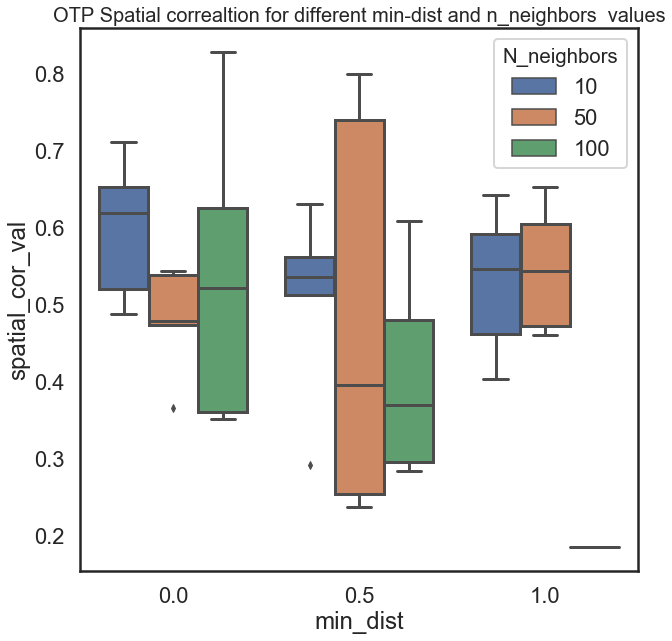

In [187]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="min_dist", y="spatial_cor_val", hue="N_neighbors", data=spatial_cor_umap_md_nn_otp)
plt.title("OTP Spatial correaltion for different min-dist and n_neighbors  values",  fontsize=20)
plt.show()

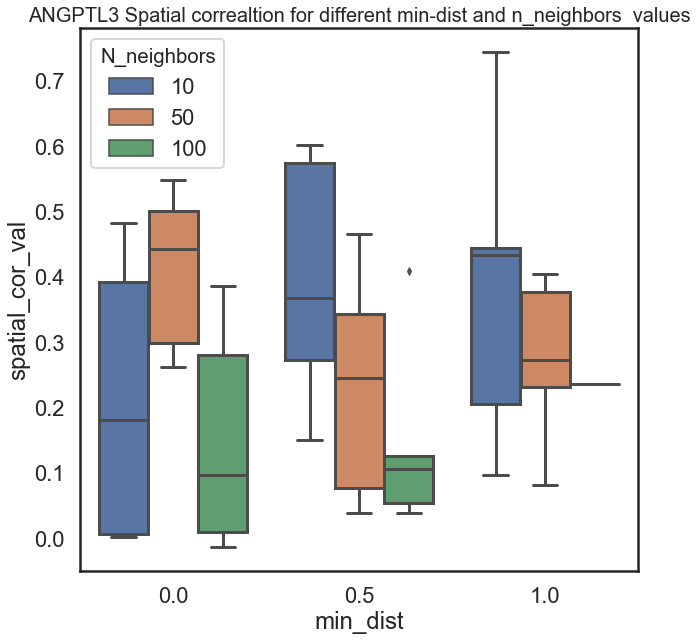

In [188]:
spatial_cor_umap_md_nn_angptl3 = spatial_cor_umap_md.loc[spatial_cor_umap_md['list_spatial_cor'] =="angptl3"]
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="min_dist", y="spatial_cor_val", hue="N_neighbors", data=spatial_cor_umap_md_nn_angptl3)
plt.title("ANGPTL3 Spatial correaltion for different min-dist and n_neighbors  values",  fontsize=20)
plt.show()


### Pulmonary carcinoids 5 classes

### Data import

In [8]:
data_lv_50_type5 =  pd.read_csv("t_data_vst_50_type_5class.tsv", sep="\t")
data_lv_50_type5.shape
data_lv_50_type5.iloc[:,6010]
lv_50_type5_data = data_lv_50_type5.iloc[:,1:6009]
lv_50_type5_type = data_lv_50_type5.iloc[:,6010]
coords_mofa_type5 = pd.read_csv("Mofa_expr_coords_5_classes.tsv", sep="\t")
ml_pred_type5  = pd.read_csv("ML_pred_fig1_5class_df.tsv", sep="\t")
Sample_ID_df_type5 =pd.DataFrame(data_lv_50_type5["Sample_ID"] )

coords_mofa_type5_v2 = pd.merge(coords_mofa_type5, Sample_ID_df_type5, on='Sample_ID', how='inner')
coords_mofa_type5 = coords_mofa_type5_v2
coords_mofa_type5.head()

spatial_attributes_type5 = pd.read_csv("Spatial_analysis_attribute_5_classes.tsv", sep="\t")
spatial_attributes_type5.head()


clusters = pd.read_csv("cluster_fig1_df.tsv", sep="\t")
clusters_v2 = pd.merge(clusters, Sample_ID_df_type5, on='Sample_ID', how='inner')
clusters=clusters_v2


data_lv_50_type5.shape

(158, 6011)

In [345]:
for i in range(len(clusters.iloc[:,1])):
    if clusters.isna().iloc[i,2] == True and clusters.iloc[i,1] == 'LCNEC' :
        clusters.iloc[i,2] = 'LCNEC'

In [346]:
typeN  = []
for i in range(len(lv_50_type5_type)):
    if lv_50_type5_type[i]== 'Atypical':
        typeN.append(1)
    elif lv_50_type5_type[i]== 'Typical':
        typeN.append(2)
    elif lv_50_type5_type[i]== 'LCNEC':
        typeN.append(3)
    elif lv_50_type5_type[i]== 'Supra_carcinoid':
        typeN.append(4)
    elif lv_50_type5_type[i]== 'Carcinoid':
        typeN.append(5)
    else :
        print("WARNING i = ", i)
        break



## Supervised - Unsupervised

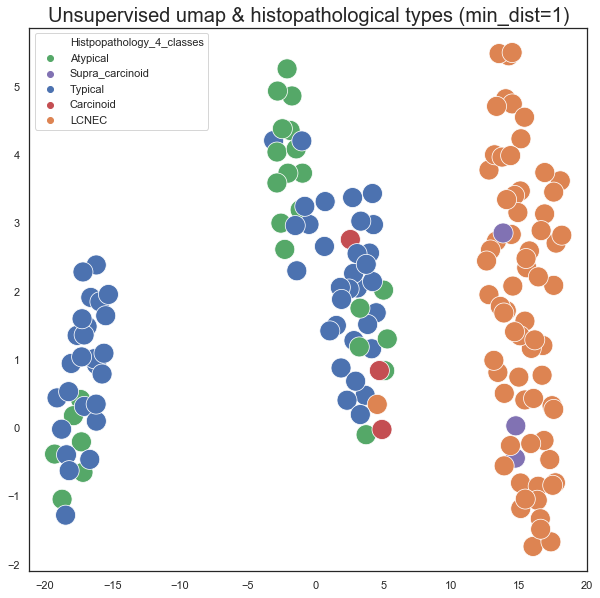

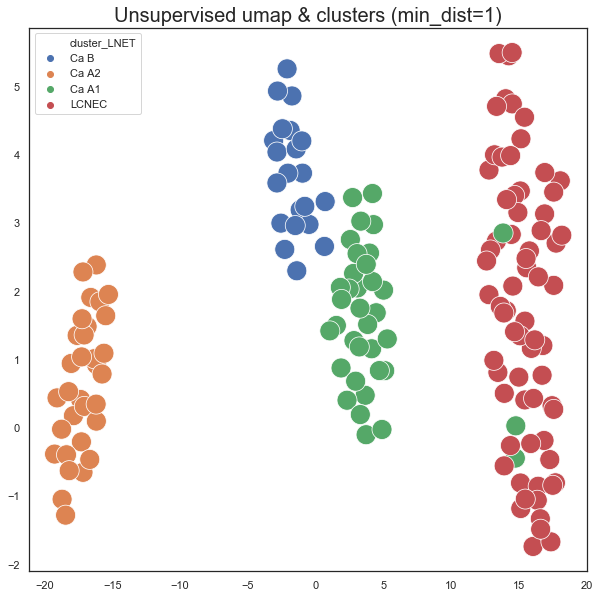

In [347]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", 'Carcinoid':'C3', 'Supra_carcinoid':'C4'}

standard_embedding = umap.UMAP(min_dist=1).fit_transform(lv_50_type5_data)
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1], s=400, hue=lv_50_type5_type, palette=palette )#
plt.title("Unsupervised umap & histopathological types (min_dist=1)",  fontsize=20)
plt.show()

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1] ,s=400,  hue=clusters.iloc[:,2])
plt.title("Unsupervised umap & clusters (min_dist=1)",  fontsize=20)
plt.show()



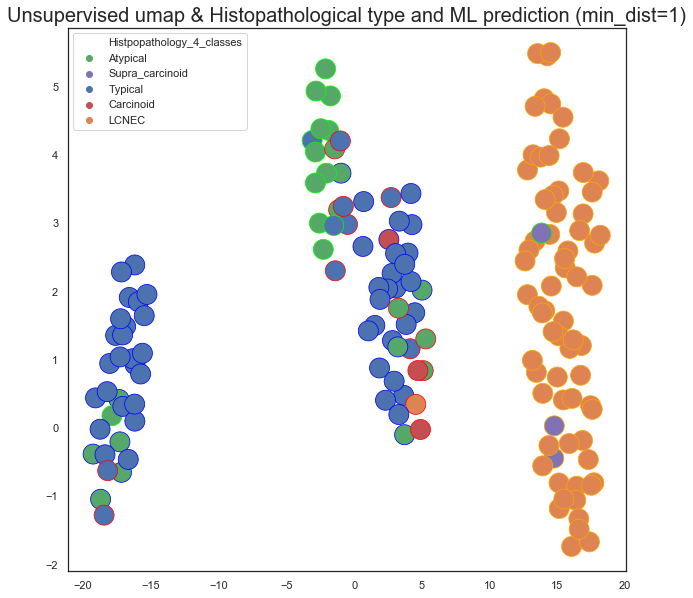

In [348]:
edges_col = []
for i in ml_pred_type5.iloc[:,1]:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    elif i == 'Unclassified':
        edges_col.append("red")
    else :
        print("warning")


sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1],  hue=lv_50_type5_type, edgecolor=  edges_col , s=400, palette=palette)
plt.title("Unsupervised umap & Histopathological type and ML prediction (min_dist=1)",  fontsize=20)
plt.show()

* blue = Typical
* orange = LCNEC
* lime = Atypical
* red  = Unclasied

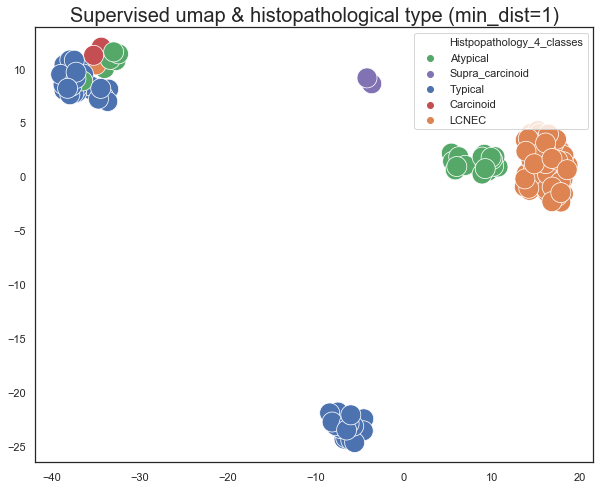

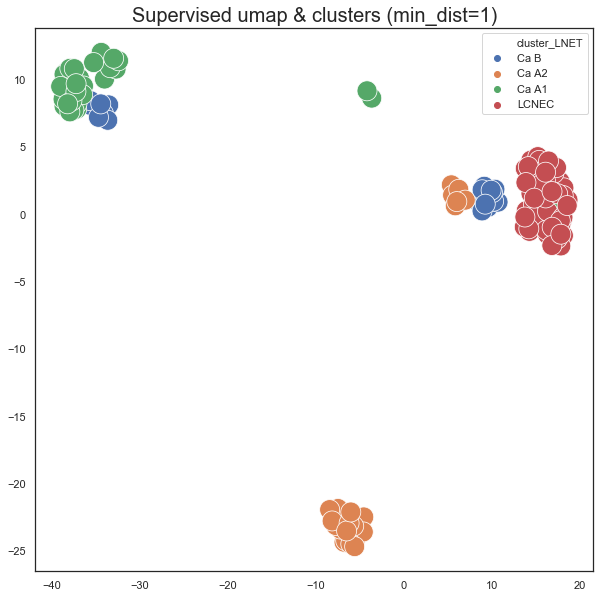

In [349]:
embedding = umap.UMAP(min_dist=1).fit_transform(lv_50_type5_data, typeN )
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=400, hue=lv_50_type5_type, palette=palette )#
plt.title("Supervised umap & histopathological type (min_dist=1)",  fontsize=20)
plt.show()

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1] ,s=400,  hue=clusters.iloc[:,2])
plt.title("Supervised umap & clusters (min_dist=1)",  fontsize=20)
plt.show()

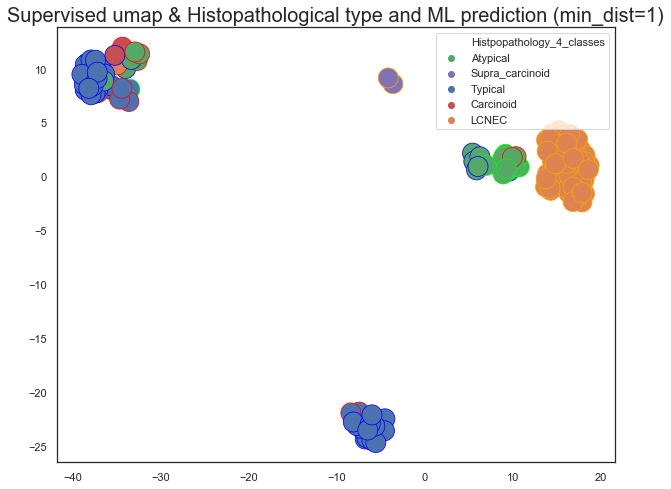

In [350]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=lv_50_type5_type, edgecolor=  edges_col , s=400, palette=palette)
plt.title("Supervised umap & Histopathological type and ML prediction (min_dist=1)",  fontsize=20)
plt.show()

## spatial auto-correlation

In [351]:
# D'après la version 1.14 de Pysal

wknn10 = pysal.lib.weights.KNN(standard_embedding, k = 20)
OTP_gene_expression = np.array(spatial_attributes_type5.iloc[:,0])
ANGPTL3_gene_expression = np.array(spatial_attributes_type5.iloc[:,1])
dendritic_cell = np.array(spatial_attributes_type5.iloc[:,2])
    
mi_otp = Moran(OTP_gene_expression, wknn10 , two_tailed=True).I
mi_angptl3 = Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True).I
mi_dendritic_cell = Moran(dendritic_cell, wknn10 , two_tailed=True).I

wknn10_pca =  pysal.lib.weights.KNN(coords_mofa_type5.iloc[:,1:], k = 20)
mi_otp_PCA = Moran(OTP_gene_expression, wknn10_pca , two_tailed=True).I
mi_angptl3_PCA = Moran(ANGPTL3_gene_expression, wknn10_pca , two_tailed=True).I
mi_dendritic_cell_PCA = Moran(dendritic_cell, wknn10_pca , two_tailed=True).I


wknn10_r =  pysal.lib.weights.KNN(lv_50_type5_data, k = 20)
mi_otp_r = Moran(OTP_gene_expression, wknn10_r , two_tailed=True).I
mi_angptl3_r = Moran(ANGPTL3_gene_expression, wknn10_r , two_tailed=True).I
mi_dendritic_cell_r = Moran(dendritic_cell, wknn10_r , two_tailed=True).I

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 3 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


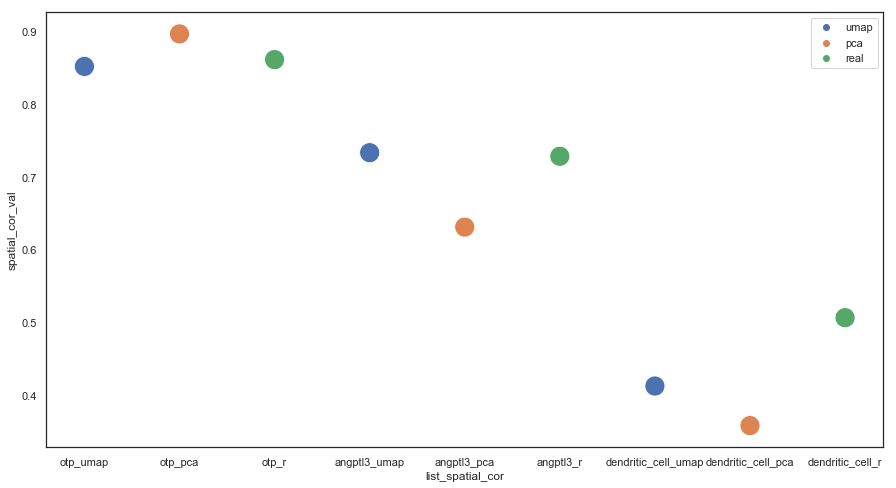

In [352]:
list_spatial_cor = ["otp_umap" , 'otp_pca', "otp_r","angptl3_umap","angptl3_pca", "angptl3_r","dendritic_cell_umap","dendritic_cell_pca", "dendritic_cell_r"]
spatial_cor_val = [mi_otp ,mi_otp_PCA , mi_otp_r , mi_angptl3,  mi_angptl3_PCA , mi_angptl3_r, mi_dendritic_cell , mi_dendritic_cell_PCA , mi_dendritic_cell_r ]
spatial_cor= pd.DataFrame() 
spatial_cor['list_spatial_cor'] = list_spatial_cor 
spatial_cor['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape
col = ['umap','pca', 'real']*3

sns.set(style='white', rc={'figure.figsize':(15,8)})
sns.scatterplot(spatial_cor.iloc[:, 0], spatial_cor.iloc[:, 1],hue=col, s=400)
plt.show()



In [353]:
min_dist_umap= min_threshold_distance(standard_embedding)
min_dist_pca= min_threshold_distance(coords_mofa_type5.iloc[:,1:]) 
min_dist_R =   min_threshold_distance(lv_50_type5_data) 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 10 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 10 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 5 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:

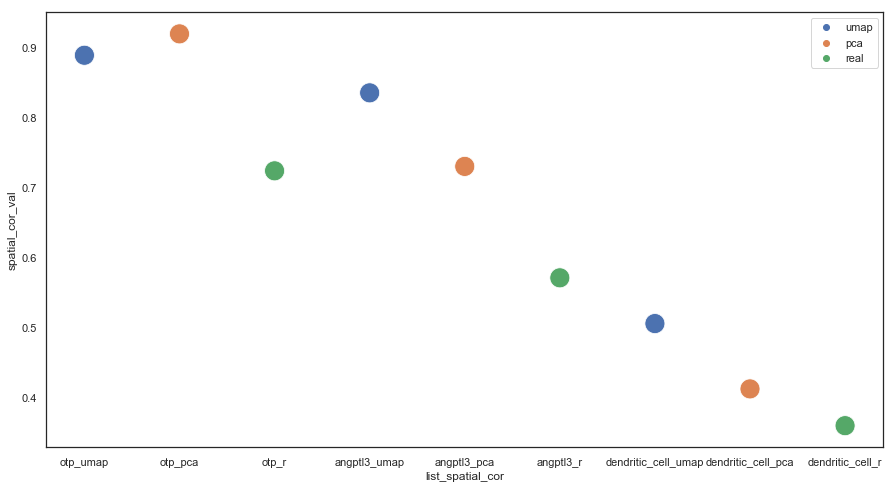

In [354]:
w_umap =  DistanceBand(standard_embedding,threshold=min_dist_umap, binary=False)
w_umap.neighbors
w_pca =  DistanceBand(coords_mofa_type5.iloc[:,1:],threshold=min_dist_pca, binary=False)
w_r = DistanceBand(lv_50_type5_data,threshold=min_dist_R , binary=False)

OTP_gene_expression = np.array(spatial_attributes_type5.iloc[:,0])
ANGPTL3_gene_expression = np.array(spatial_attributes_type5.iloc[:,1])
dendritic_cell = np.array(spatial_attributes_type5.iloc[:,2])
    
mi_otp_umap =Moran(OTP_gene_expression, w_umap , two_tailed=True).I
mi_otp_pca = Moran(OTP_gene_expression, w_pca , two_tailed=True).I
mi_otp_r = Moran(OTP_gene_expression, w_r , two_tailed=True).I


mi_angptl3_umap = Moran(ANGPTL3_gene_expression, w_umap , two_tailed=True).I
mi_angptl3_pca = Moran(ANGPTL3_gene_expression, w_pca , two_tailed=True).I
mi_angptl3_r = Moran(ANGPTL3_gene_expression, w_r , two_tailed=True).I


mi_dendritic_cell_umap = Moran(dendritic_cell, w_umap , two_tailed=True).I
mi_dendritic_cell_pca = Moran(dendritic_cell, w_pca , two_tailed=True).I
mi_dendritic_cell_r = Moran(dendritic_cell, w_r , two_tailed=True).I

list_spatial_cor = ["otp_umap" , 'otp_pca', 'otp_r',"angptl3_umap","angptl3_pca",'angptl3_r',"dendritic_cell_umap","dendritic_cell_pca", "dendritic_cell_r"]
spatial_cor_val = [mi_otp_umap ,mi_otp_pca,  mi_otp_r , mi_angptl3_umap,  mi_angptl3_pca, mi_angptl3_r , mi_dendritic_cell_umap , mi_dendritic_cell_pca, mi_dendritic_cell_r ]
spatial_cor= pd.DataFrame() 
spatial_cor['list_spatial_cor'] = list_spatial_cor 
spatial_cor['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape

col = ['umap','pca', 'real']*3
sns.set(style='white', rc={'figure.figsize':(15,8)})
sns.scatterplot(spatial_cor.iloc[:, 0], spatial_cor.iloc[:, 1],hue=col, s=400)
plt.show()

### Knn prediction

In [ ]:
knn_acc=[]
kmeans_acc=[]
knn_pred =[]
kmeans_pred=[]
lv_50_type5_df = pd.DataFrame(lv_50_type5_type) 
original_histo = []
ml_original = []
Sample =[]
skf = StratifiedKFold(n_splits=5)#, shuffle=True
trans = umap.UMAP().fit(lv_50_type5_data)
test_embedding_0 = []
test_embedding_1 = []
checked_index = []
for train_index, test_index in skf.split(lv_50_type5_data, lv_50_type5_df):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = lv_50_type5_data.iloc[train_index,:], lv_50_type5_data.iloc[test_index,:]
        y_train, y_test =lv_50_type5_df.iloc[train_index,:].values.tolist(), lv_50_type5_df.iloc[test_index,:].values.tolist()
        y_train= list(itertools.chain(*y_train))
        y_test = list(itertools.chain(*y_test))
        checked_index.append(test_index)
        #print('test_index', test_index)
        #svc_2 = SVC().fit(trans.embedding_, y_train)
        knn_2 = KNeighborsClassifier().fit(trans.embedding_[train_index,:], y_train)
        kmeans_2 = KMeans(n_clusters=len(set(y_test))).fit(trans.embedding_[train_index,:], y_train)
        
        test_embedding = trans.transform(X_test)
        test_embedding_0.append(test_embedding[:,0] )
        test_embedding_1.append(test_embedding[:,1] )
        for  z in range(len(test_index)):
            original_histo.append(lv_50_type5_df.iloc[test_index[z],:].values)
            ml_original.append(ml_pred_type5.iloc[test_index[z],1])
    
        #svc_pred_2= svc_2.predict(test_embedding)
        knn_pred_2 = knn_2.predict(test_embedding)
        kmeans_pred_2 = kmeans_2.predict(test_embedding)
        kmean_acc_2 , kmean_lab_2 =label_pred(list(y_test),list(kmeans_pred_2 ))
        
        knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
        #svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
        kmeans_acc.append(kmean_acc_2)
        knn_pred.append(knn_pred_2 )
        kmeans_pred.append(kmean_lab_2)
knn_pred = list(itertools.chain(*knn_pred))
kmeans_pred = list(itertools.chain(*kmeans_pred))
#print('ml_original', ml_original)
original_histo = list(itertools.chain(*original_histo ))
#ml_original = list(itertools.chain(*ml_original ))

edges_col = []
for i in knn_pred:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Supra_carcinoid":
        edges_col.append("purple")
    elif i == 'Atypical':
        edges_col.append("lime")
    elif i == 'Carcinoid':
        edges_col.append("red")
    else :
        print('i',i)
        print("warning")


test_embedding_0  = list(itertools.chain(*test_embedding_0))
test_embedding_1  = list(itertools.chain(*test_embedding_1))
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", 'Carcinoid':'C3', 'Supra_carcinoid':'C4'}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=test_embedding_0, y=test_embedding_1,  hue=original_histo,edgecolor=  edges_col , s=400, palette=palette)
plt.title("KNN predictions on UMAP Layout(min_dist=1)",  fontsize=20)
plt.show()

edges_col = []
for i in kmeans_pred:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Supra_carcinoid":
        edges_col.append("purple")
    elif i == 'Atypical':
        edges_col.append("lime")
    elif i == 'Carcinoid':
        edges_col.append("red")
    else :
        print('i',i)
        print("warning")

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=test_embedding_0, y=test_embedding_1,  hue=original_histo, edgecolor =  edges_col , s=400, palette=palette)
plt.title("KMEANS predictions on UMAP Layout(min_dist=1)",  fontsize=20)
plt.show()



edges_col = []
for i in ml_original:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    elif i == 'Unclassified':
        edges_col.append("red")
    else :
        print("warning")

palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", 'Carcinoid':'C3', 'Supra_carcinoid':'C4'}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=test_embedding_0, y=test_embedding_1,  hue=knn_pred , edgecolor=  edges_col , s=400, palette=palette)
plt.title("KNN predictions with ML predictions on UMAP Layout(min_dist=1)",  fontsize=20)
plt.show()

In [ ]:
predict_df = pd.DataFrame()
predict_df['knn_pred'] = knn_pred
predict_df["ml_pred"] = ml_original

tab = pd.crosstab( predict_df['knn_pred'] , predict_df["ml_pred"] )

sns.heatmap(tab)
tab

In [ ]:
predict_df = pd.DataFrame()
predict_df['original'] = original_histo
predict_df['knn_pred'] = knn_pred
tab = pd.crosstab( predict_df['knn_pred'] ,predict_df['original'] )

sns.heatmap(tab)
tab

In [ ]:
predict_df = pd.DataFrame()
predict_df['original'] = original_histo
predict_df['ml'] = ml_original
tab = pd.crosstab( predict_df['ml'] ,predict_df['original'] )

sns.heatmap(tab)
tab

#### PCA

In [ ]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", "diffuse_NOS":"C4", "Supra_carcinoid": "C5"}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(coords_mofa_type5.iloc[:, 1], coords_mofa_type5.iloc[:, 2],  hue=lv_50_type5_type ,s=400, palette=palette)
plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(coords_mofa_type5.iloc[:, 1], coords_mofa_type5.iloc[:, 2],  hue=cluster_lnen.iloc[:,1] ,s=400)
plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()

# Mesomics 

## Import data

In [ ]:
meso_data_type =  pd.read_csv("Meso_data_lv_sample_type.tsv", sep="\t")
meso_data_type.head()
meso_data_type.shape
meso_pca_coords =  pd.read_csv("PCA_coords_MESO.tsv", sep="\t")
palette ={"Biphasic":"darkorange","Diffuse_NOS":"black","Epithelioid":"mediumseagreen", "Sarcomatoid":"tomato"}

In [ ]:
data_expr_meso = meso_data_type.iloc[:,1:7145]
data_type_meso = meso_data_type.iloc[:,7146]

## Supervised Unsupervised

In [ ]:
typeN_meso  = []
for i in range(len(data_type_meso)):
    if data_type_meso[i]== 'Biphasic':
        typeN_meso.append(1)
    elif data_type_meso[i]== 'Diffuse_NOS':
        typeN_meso.append(2)
    elif data_type_meso[i]== 'Epithelioid':
        typeN_meso.append(3)
    elif data_type_meso[i]== 'Sarcomatoid':  
        typeN_meso.append(4)
    else :
        print("WARNING i = ", i)
        break
palette_N ={1:"darkorange",2:"black",3:"mediumseagreen", 4:"tomato"}

### Unsupervised

In [ ]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
standard_embedding_meso = umap.UMAP().fit_transform(data_expr_meso )
sns.scatterplot(x=standard_embedding_meso[:, 0], y=standard_embedding_meso[:, 1], s=400, hue=data_type_meso, palette=palette)
plt.show()

### Supervised

In [ ]:
embedding = umap.UMAP( min_dist = 0.99).fit_transform(data_expr_meso , y=typeN_meso)
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=400, hue=data_type_meso , palette =palette)
plt.show()

### Spatial correlation 
#### Import features

In [ ]:
Meso_spatial_cor_data =  pd.read_csv("Meso_spatial_cor_att.tsv", sep="\t")

In [360]:
knn_acc=[]
kmeans_acc=[]

knn_pred =[]
kmeans_pred=[]

lv_50_type5_df = pd.DataFrame(data_type_meso)
original_histo = []

Sample =[]
skf = StratifiedKFold(n_splits=5)#, shuffle=True
trans = umap.UMAP().fit(data_expr_meso)
test_embedding_0 = []
test_embedding_1 = []
checked_index = []
for train_index, test_index in skf.split(data_expr_meso ,data_type_meso):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = data_expr_meso.iloc[train_index,:],data_expr_meso.iloc[test_index,:]
        y_train, y_test =data_type_meso.iloc[train_index], data_type_meso.iloc[test_index]
       
        knn_2 = KNeighborsClassifier().fit(trans.embedding_[train_index,:], y_train)
        kmeans_2 = KMeans(n_clusters=len(set(y_test))).fit(trans.embedding_[train_index,:], y_train)
        
        test_embedding = trans.transform(X_test)
        test_embedding_0.append(test_embedding[:,0] )
        test_embedding_1.append(test_embedding[:,1] )
        for  z in range(len(test_index)):
            original_histo.append(data_type_meso[test_index[z]])
           
        #svc_pred_2= svc_2.predict(test_embedding)
        knn_pred_2 = knn_2.predict(test_embedding)
        kmeans_pred_2 = kmeans_2.predict(test_embedding)
        kmean_acc_2 , kmean_lab_2 =label_pred(list(y_test),list(kmeans_pred_2 ))
        
        knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
        #svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
        kmeans_acc.append(kmean_acc_2)
        knn_pred.append(knn_pred_2 )
        kmeans_pred.append(kmean_lab_2)
knn_pred = list(itertools.chain(*knn_pred))
kmeans_pred = list(itertools.chain(*kmeans_pred))
#print(original_histo)


edges_col = []
for i in knn_pred:
    if i == "Epithelioid":
        edges_col.append("lime")
    elif i == "Biphasic":
        edges_col.append("orange")
    elif i == "Diffuse_NOS":
        edges_col.append("black")
    elif i == 'Sarcomatoid':
        edges_col.append("red")
    else :
        print('i',i)
        print("warning")


test_embedding_0  = list(itertools.chain(*test_embedding_0))
test_embedding_1  = list(itertools.chain(*test_embedding_1))
palette_N ={"Biphasic":"darkorange","Diffuse_NOS":"black","Epithelioid":"mediumseagreen", 'Sarcomatoid':"tomato"}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=test_embedding_0, y=test_embedding_1,  hue=original_histo,edgecolor=  edges_col , s=400, palette=palette)
plt.title("KNN predictions on UMAP Layout(min_dist=1)",  fontsize=20)
plt.show()

edges_col = []
for i in kmeans_pred:
    if i == "Epithelioid":
        edges_col.append("lime")
    elif i == "Biphasic":
        edges_col.append("orange")
    elif i == "Diffuse_NOS":
        edges_col.append("black")
    elif i == 'Sarcomatoid':
        edges_col.append("red")
    else :
        print('i',i)
        print("warning")

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=test_embedding_0, y=test_embedding_1,  hue=original_histo, edgecolor =  edges_col , s=400, palette=palette_N)
plt.title("KMEANS predictions on UMAP Layout(min_dist=1)",  fontsize=20)
plt.show()

print()


ValueError: The palette dictionary is missing keys: {'Diffuse_NOS', 'Sarcomatoid', 'Biphasic', 'Epithelioid'}

In [ ]:
precision_score(original_histo, knn_pred, average='weighted')

In [ ]:
knn_acc=[]
kmeans_acc=[]

knn_pred =[]
kmeans_pred=[]

lv_50_type5_df = pd.DataFrame(data_type_meso)
original_histo = []

Sample =[]
skf = StratifiedKFold(n_splits=5)#, shuffle=True
trans = meso_pca_coords.iloc[:,1:] 
test_embedding_0 = []
test_embedding_1 = []
checked_index = []
for train_index, test_index in skf.split(data_expr_meso ,data_type_meso):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = data_expr_meso.iloc[train_index,:],data_expr_meso.iloc[test_index,:]
        y_train, y_test =data_type_meso.iloc[train_index], data_type_meso.iloc[test_index]
       
        knn_2 = KNeighborsClassifier().fit(trans.iloc[train_index,:], y_train)
        kmeans_2 = KMeans(n_clusters=len(set(y_test))).fit(trans.iloc[train_index,:], y_train)
        
        test_embedding = trans.iloc[test_index,:]
        test_embedding_0.append( test_embedding.iloc[:,0])
        test_embedding_1.append(  test_embedding.iloc[:,1] )
        for  z in range(len(test_index)):
            original_histo.append(data_type_meso[test_index[z]])
           
        #svc_pred_2= svc_2.predict(test_embedding)
        knn_pred_2 = knn_2.predict(test_embedding)
        kmeans_pred_2 = kmeans_2.predict(test_embedding)
        #kmean_acc_2 , kmean_lab_2 =label_pred(list(y_test),list(kmeans_pred_2 ))
        
        #knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
        #svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
        #kmeans_acc.append(kmean_acc_2)
        knn_pred.append(knn_pred_2 )
        kmeans_pred.append(kmean_lab_2)
knn_pred = list(itertools.chain(*knn_pred))
kmeans_pred = list(itertools.chain(*kmeans_pred))
#print(original_histo)


edges_col = []
for i in knn_pred:
    if i == "Epithelioid":
        edges_col.append("lime")
    elif i == "Biphasic":
        edges_col.append("orange")
    elif i == "Diffuse_NOS":
        edges_col.append("black")
    elif i == 'Sarcomatoid':
        edges_col.append("red")
    else :
        print('i',i)
        print("warning")


test_embedding_0  = list(itertools.chain(*test_embedding_0))
test_embedding_1  = list(itertools.chain(*test_embedding_1))
palette_N ={"Biphasic":"darkorange","Diffuse_NOS":"black","Epithelioid":"mediumseagreen", 'Sarcomatoid':"tomato"}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=test_embedding_0, y=test_embedding_1,  hue=original_histo,edgecolor=  edges_col , s=400, palette=palette)
plt.title("KNN predictions on UMAP Layout(min_dist=1)",  fontsize=20)
plt.show()

edges_col = []
for i in kmeans_pred:
    if i == "Epithelioid":
        edges_col.append("lime")
    elif i == "Biphasic":
        edges_col.append("orange")
    elif i == "Diffuse_NOS":
        edges_col.append("black")
    elif i == 'Sarcomatoid':
        edges_col.append("red")
    else :
        print('i',i)
        print("warning")

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=test_embedding_0, y=test_embedding_1,  hue=original_histo, edgecolor =  edges_col , s=400, palette=palette_N)
plt.title("KMEANS predictions on UMAP Layout(min_dist=1)",  fontsize=20)
plt.show()

print()



In [ ]:
precision_score(original_histo, knn_pred, average='weighted')

### Spatial correlation

In [361]:
# D'après la version 1.14 de Pysal
#standard_embedding = pd.DataFrame()
#standard_embedding["x"] = test_embedding_0 
#standard_embedding["y"] = test_embedding_1 
#standard_embedding = standard_embedding.values


standard_embedding  = umap.UMAP( min_dist = 0.99).fit_transform(data_expr_meso)

In [362]:
min_dist_umap= min_threshold_distance(standard_embedding)
min_dist_pca= min_threshold_distance(meso_pca_coords.iloc[:,1:].values) 
min_dist_R =   min_threshold_distance(data_expr_meso) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:17

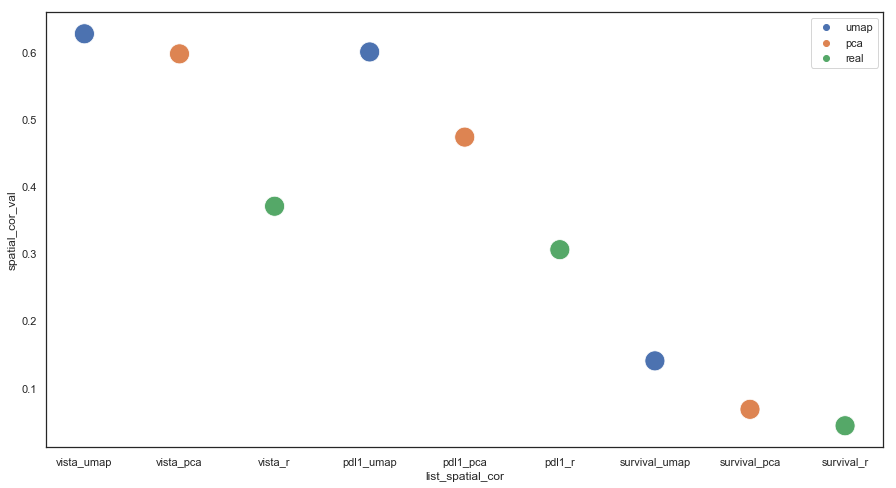

In [363]:
w_umap =  DistanceBand(standard_embedding,threshold=min_dist_umap, binary=False)
w_umap.neighbors
w_pca =  DistanceBand(meso_pca_coords.iloc[:,1:],threshold=min_dist_pca, binary=False)
w_r = DistanceBand(data_expr_meso,threshold=min_dist_R , binary=False)

VISTA_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,0])
PDL1_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,1])
Survival = np.array(Meso_spatial_cor_data.iloc[:,2])
    
mi_VISTA_umap =Moran(VISTA_gene_expression, w_umap , two_tailed=True).I
mi_VISTA_pca = Moran(VISTA_gene_expression, w_pca , two_tailed=True).I
mi_VISTA_r = Moran(VISTA_gene_expression, w_r , two_tailed=True).I


mi_PDL1_umap = Moran(PDL1_gene_expression, w_umap , two_tailed=True).I
mi_PDL1_pca = Moran(PDL1_gene_expression, w_pca , two_tailed=True).I
mi_PDL1_r = Moran(PDL1_gene_expression, w_r , two_tailed=True).I


mi_Survival_umap = Moran(Survival, w_umap , two_tailed=True).I
mi_Survival_pca = Moran(Survival, w_pca , two_tailed=True).I
mi_Survival_r = Moran(Survival, w_r , two_tailed=True).I

list_spatial_cor = ["vista_umap" , 'vista_pca', 'vista_r',"pdl1_umap","pdl1_pca",'pdl1_r',"survival_umap","survival_pca", "survival_r"]
spatial_cor_val = [mi_VISTA_umap ,mi_VISTA_pca,  mi_VISTA_r , mi_PDL1_umap,  mi_PDL1_pca, mi_PDL1_r , mi_Survival_umap , mi_Survival_pca, mi_Survival_r ]
spatial_cor= pd.DataFrame() 
spatial_cor['list_spatial_cor'] = list_spatial_cor 
spatial_cor['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape

col = ['umap','pca', 'real']*3
sns.set(style='white', rc={'figure.figsize':(15,8)})
sns.scatterplot(spatial_cor.iloc[:, 0], spatial_cor.iloc[:, 1],hue=col, s=400)
plt.show()

spatial_cor1 = spatial_cor

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:17

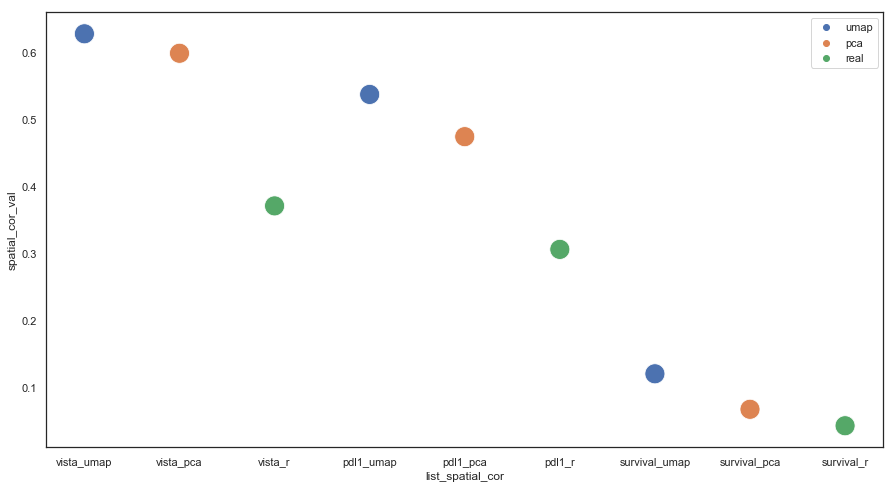

In [364]:
standard_embedding  = umap.UMAP( ).fit_transform(data_expr_meso)
w_umap =  DistanceBand(standard_embedding,threshold=min_dist_umap, binary=False)
w_umap.neighbors
w_pca =  DistanceBand(meso_pca_coords.iloc[:,1:],threshold=min_dist_pca, binary=False)
w_r = DistanceBand(data_expr_meso,threshold=min_dist_R , binary=False)

VISTA_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,0])
PDL1_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,1])
Survival = np.array(Meso_spatial_cor_data.iloc[:,2])
    
mi_VISTA_umap =Moran(VISTA_gene_expression, w_umap , two_tailed=True).I
mi_VISTA_pca = Moran(VISTA_gene_expression, w_pca , two_tailed=True).I
mi_VISTA_r = Moran(VISTA_gene_expression, w_r , two_tailed=True).I


mi_PDL1_umap = Moran(PDL1_gene_expression, w_umap , two_tailed=True).I
mi_PDL1_pca = Moran(PDL1_gene_expression, w_pca , two_tailed=True).I
mi_PDL1_r = Moran(PDL1_gene_expression, w_r , two_tailed=True).I


mi_Survival_umap = Moran(Survival, w_umap , two_tailed=True).I
mi_Survival_pca = Moran(Survival, w_pca , two_tailed=True).I
mi_Survival_r = Moran(Survival, w_r , two_tailed=True).I

list_spatial_cor = ["vista_umap" , 'vista_pca', 'vista_r',"pdl1_umap","pdl1_pca",'pdl1_r',"survival_umap","survival_pca", "survival_r"]
spatial_cor_val = [mi_VISTA_umap ,mi_VISTA_pca,  mi_VISTA_r , mi_PDL1_umap,  mi_PDL1_pca, mi_PDL1_r , mi_Survival_umap , mi_Survival_pca, mi_Survival_r ]
spatial_cor= pd.DataFrame() 
spatial_cor['list_spatial_cor'] = list_spatial_cor 
spatial_cor['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape

col = ['umap','pca', 'real']*3
sns.set(style='white', rc={'figure.figsize':(15,8)})
sns.scatterplot(spatial_cor.iloc[:, 0], spatial_cor.iloc[:, 1],hue=col, s=400)
plt.show()

spatial_cor2 = spatial_cor

In [365]:
spatial_cor1 

,list_spatial_cor,spatial_cor_val
0,vista_umap,0.627966
1,vista_pca,0.598027
2,vista_r,0.370663
3,pdl1_umap,0.600883
4,pdl1_pca,0.473796
5,pdl1_r,0.305865
6,survival_umap,0.139960
7,survival_pca,0.067646
8,survival_r,0.043143


In [366]:
spatial_cor2

,list_spatial_cor,spatial_cor_val
0,vista_umap,0.627048
1,vista_pca,0.598027
2,vista_r,0.370663
3,pdl1_umap,0.536701
4,pdl1_pca,0.473796
5,pdl1_r,0.305865
6,survival_umap,0.120534
7,survival_pca,0.067646
8,survival_r,0.043143


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pysal/lib/weights/weights.py:17

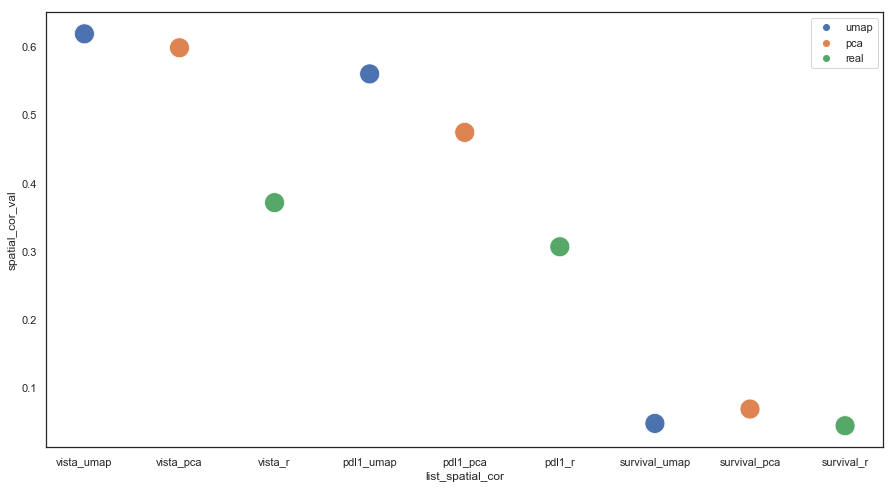

In [367]:
standard_embedding  = umap.UMAP(min_dist = 0.99, n_neighbors = 150 ).fit_transform(data_expr_meso)
w_umap =  DistanceBand(standard_embedding,threshold=min_dist_umap, binary=False)
w_umap.neighbors
w_pca =  DistanceBand(meso_pca_coords.iloc[:,1:],threshold=min_dist_pca, binary=False)
w_r = DistanceBand(data_expr_meso,threshold=min_dist_R , binary=False)

VISTA_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,0])
PDL1_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,1])
Survival = np.array(Meso_spatial_cor_data.iloc[:,2])
    
mi_VISTA_umap =Moran(VISTA_gene_expression, w_umap , two_tailed=True).I
mi_VISTA_pca = Moran(VISTA_gene_expression, w_pca , two_tailed=True).I
mi_VISTA_r = Moran(VISTA_gene_expression, w_r , two_tailed=True).I


mi_PDL1_umap = Moran(PDL1_gene_expression, w_umap , two_tailed=True).I
mi_PDL1_pca = Moran(PDL1_gene_expression, w_pca , two_tailed=True).I
mi_PDL1_r = Moran(PDL1_gene_expression, w_r , two_tailed=True).I


mi_Survival_umap = Moran(Survival, w_umap , two_tailed=True).I
mi_Survival_pca = Moran(Survival, w_pca , two_tailed=True).I
mi_Survival_r = Moran(Survival, w_r , two_tailed=True).I

list_spatial_cor = ["vista_umap" , 'vista_pca', 'vista_r',"pdl1_umap","pdl1_pca",'pdl1_r',"survival_umap","survival_pca", "survival_r"]
spatial_cor_val = [mi_VISTA_umap ,mi_VISTA_pca,  mi_VISTA_r , mi_PDL1_umap,  mi_PDL1_pca, mi_PDL1_r , mi_Survival_umap , mi_Survival_pca, mi_Survival_r ]
spatial_cor= pd.DataFrame() 
spatial_cor['list_spatial_cor'] = list_spatial_cor 
spatial_cor['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape

col = ['umap','pca', 'real']*3
sns.set(style='white', rc={'figure.figsize':(15,8)})
sns.scatterplot(spatial_cor.iloc[:, 0], spatial_cor.iloc[:, 1],hue=col, s=400)
plt.show()

spatial_cor2 = spatial_cor

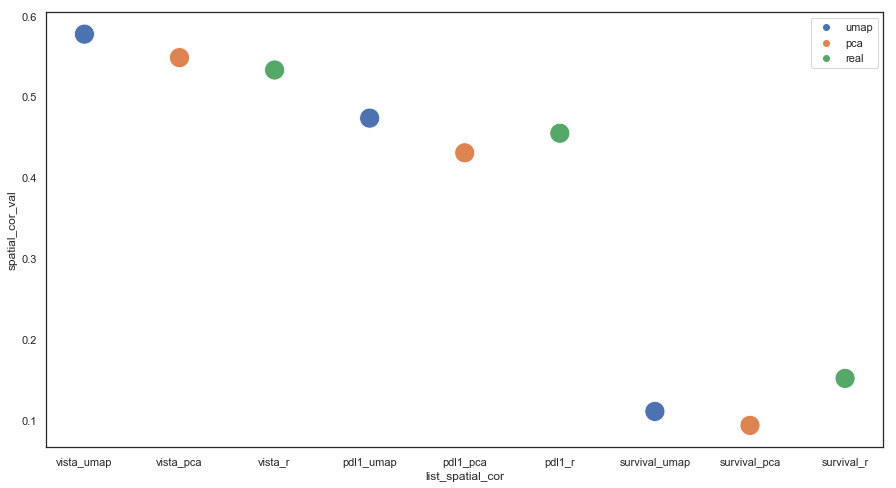

In [368]:

standard_embedding  = umap.UMAP(min_dist = 0.99, n_neighbors = 150 ).fit_transform(data_expr_meso)
w_umap = pysal.lib.weights.KNN(standard_embedding, k = 20)
w_umap.neighbors
w_pca = pysal.lib.weights.KNN(meso_pca_coords.iloc[:,1:], k = 20)
w_r = pysal.lib.weights.KNN(data_expr_meso, k = 20) #DistanceBand(data_expr_meso,threshold=min_dist_R , binary=False)

VISTA_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,0])
PDL1_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,1])
Survival = np.array(Meso_spatial_cor_data.iloc[:,2])
    
mi_VISTA_umap =Moran(VISTA_gene_expression, w_umap , two_tailed=True).I
mi_VISTA_pca = Moran(VISTA_gene_expression, w_pca , two_tailed=True).I
mi_VISTA_r = Moran(VISTA_gene_expression, w_r , two_tailed=True).I


mi_PDL1_umap = Moran(PDL1_gene_expression, w_umap , two_tailed=True).I
mi_PDL1_pca = Moran(PDL1_gene_expression, w_pca , two_tailed=True).I
mi_PDL1_r = Moran(PDL1_gene_expression, w_r , two_tailed=True).I


mi_Survival_umap = Moran(Survival, w_umap , two_tailed=True).I
mi_Survival_pca = Moran(Survival, w_pca , two_tailed=True).I
mi_Survival_r = Moran(Survival, w_r , two_tailed=True).I

list_spatial_cor = ["vista_umap" , 'vista_pca', 'vista_r',"pdl1_umap","pdl1_pca",'pdl1_r',"survival_umap","survival_pca", "survival_r"]
spatial_cor_val = [mi_VISTA_umap ,mi_VISTA_pca,  mi_VISTA_r , mi_PDL1_umap,  mi_PDL1_pca, mi_PDL1_r , mi_Survival_umap , mi_Survival_pca, mi_Survival_r ]
spatial_cor= pd.DataFrame() 
spatial_cor['list_spatial_cor'] = list_spatial_cor 
spatial_cor['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape

col = ['umap','pca', 'real']*3
sns.set(style='white', rc={'figure.figsize':(15,8)})
sns.scatterplot(spatial_cor.iloc[:, 0], spatial_cor.iloc[:, 1],hue=col, s=400)
plt.show()

spatial_cor2 = spatial_cor

[(0, 6), (0, 10), (0, 25), (0, 37), (0, 39), (0, 40), (0, 45), (0, 55), (0, 60), (0, 70), (0, 76), (0, 89), (0, 95), (0, 106), (0, 115), (0, 121), (0, 122), (0, 124), (0, 125), (0, 126), (0, 136), (0, 139), (0, 152), (0, 158), (0, 161), (0, 162), (0, 164), (0, 167), (0, 177), (0, 181), (0, 184), (0, 197), (0, 198), (0, 207), (0, 209), (0, 212), (0, 213), (0, 214), (0, 217), (0, 223), (0, 225), (0, 230), (0, 231), (0, 233), (0, 236), (0, 239), (0, 243), (0, 248), (0, 259), (0, 261), (0, 262), (0, 280), (0, 281), (1, 6), (1, 22), (1, 23), (1, 25), (1, 37), (1, 39), (1, 40), (1, 58), (1, 60), (1, 76), (1, 78), (1, 89), (1, 111), (1, 114), (1, 139), (1, 152), (1, 153), (1, 161), (1, 162), (1, 164), (1, 174), (1, 177), (1, 192), (1, 201), (1, 209), (1, 217), (1, 231), (1, 236), (1, 237), (1, 248), (1, 251), (1, 252), (1, 275), (1, 276), (1, 280), (1, 281), (2, 3), (2, 17), (2, 19), (2, 27), (2, 33), (2, 35), (2, 38), (2, 41), (2, 57), (2, 59), (2, 69), (2, 72), (2, 74), (2, 81), (2, 104), (

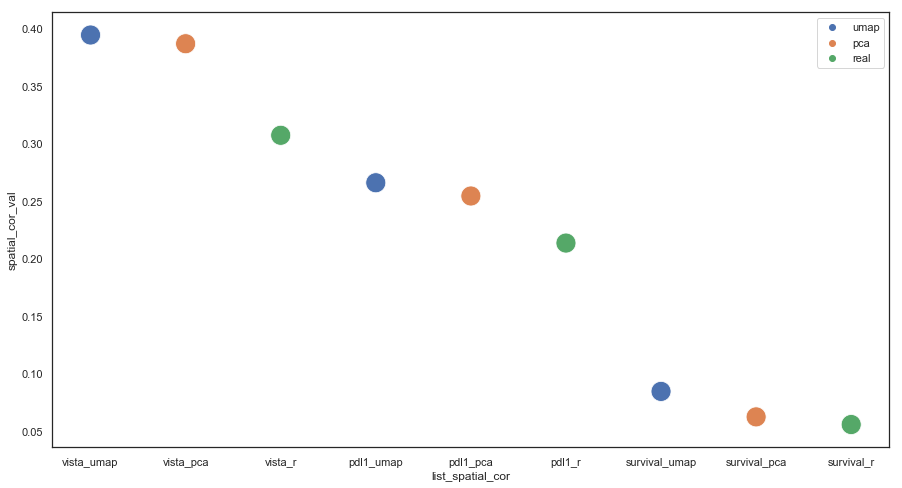

In [372]:

standard_embedding  = umap.UMAP(min_dist = 0.99, n_neighbors = 150 ).fit_transform(data_expr_meso)
w_umap = pysal.lib.weights.KNN(standard_embedding, k = 100)
#print(w_umap.neighbors)
print(w_umap.asymmetries)
print(w_umap.cardinalities)
print(w_umap.histogram)
w_pca = pysal.lib.weights.KNN(meso_pca_coords.iloc[:,1:], k = 100)
w_r = pysal.lib.weights.KNN(data_expr_meso, k = 100) #DistanceBand(data_expr_meso,threshold=min_dist_R , binary=False)

VISTA_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,0])
PDL1_gene_expression = np.array(Meso_spatial_cor_data.iloc[:,1])
Survival = np.array(Meso_spatial_cor_data.iloc[:,2])
    
mi_VISTA_umap =Moran(VISTA_gene_expression, w_umap , two_tailed=True).I
mi_VISTA_pca = Moran(VISTA_gene_expression, w_pca , two_tailed=True).I
mi_VISTA_r = Moran(VISTA_gene_expression, w_r , two_tailed=True).I


mi_PDL1_umap = Moran(PDL1_gene_expression, w_umap , two_tailed=True).I
mi_PDL1_pca = Moran(PDL1_gene_expression, w_pca , two_tailed=True).I
mi_PDL1_r = Moran(PDL1_gene_expression, w_r , two_tailed=True).I


mi_Survival_umap = Moran(Survival, w_umap , two_tailed=True).I
mi_Survival_pca = Moran(Survival, w_pca , two_tailed=True).I
mi_Survival_r = Moran(Survival, w_r , two_tailed=True).I

list_spatial_cor = ["vista_umap" , 'vista_pca', 'vista_r',"pdl1_umap","pdl1_pca",'pdl1_r',"survival_umap","survival_pca", "survival_r"]
spatial_cor_val = [mi_VISTA_umap ,mi_VISTA_pca,  mi_VISTA_r , mi_PDL1_umap,  mi_PDL1_pca, mi_PDL1_r , mi_Survival_umap , mi_Survival_pca, mi_Survival_r ]
spatial_cor= pd.DataFrame() 
spatial_cor['list_spatial_cor'] = list_spatial_cor 
spatial_cor['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape

col = ['umap','pca', 'real']*3
sns.set(style='white', rc={'figure.figsize':(15,8)})
sns.scatterplot(spatial_cor.iloc[:, 0], spatial_cor.iloc[:, 1],hue=col, s=400)
plt.show()

spatial_cor2 = spatial_cor